# Exploratory Data Analysis (EDA)

## Why do EDA?

EDA helps uncover statistical properties, temporal patterns, and feature-target relationships that guide model development.  
It ensures we understand the structure and dynamics of the dataset before applying any forecasting models.

---

## EDA Structure

This notebook is divided into two main parts:

**I. Historical Arrival Process (2009–2025)**  

Analyze long-term trends in Bitcoin fee dynamics using historical data. Evaluate whether the arrival pattern follows a Poisson process, providing statistical grounding for subsequent model choices.

**II. EDA on Project Dataset**  

1. **Dataset & Feature Summary** – Provide data overview, cleaning, and feature summary statistics & visualizations  
2. **Distributional Insights** – Assess distribution shapes, skewness, and transformations  
3. **Feature Correlations** – Identify correlated predictors via heatmaps and significance testing  
4. **Stationarity Checks** – Evaluate the need for differencing and seasonal modeling  
5. **Time Series Decomposition** – Evaluate time series components like trend, seasonality, and residuals
6. **Temporal Patterns** – Explore ACF/PACF patterns and lag dependencies  
7. **Optimal Sampling Frequency** – Determine the best sampling frequency for modeling
8. **Modeling Strategy** – Summarize EDA-driven insights and justify model selection

> **Note:** If you're interested in how these plots are generated, the helper functions used to generate plots in this notebook are located in [scripts/data_spec/eda_utils.py](../scripts/data_spec/utils.py).

## Import Libraries

We import core libraries and load the raw dataset for downstream analysis.

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
scripts_path = Path("..") / "scripts"
sys.path.append(str(scripts_path.resolve()))
from data_spec.eda_utils import plot_feature_group, plot_decomposition_custom, plot_group_correlation


# I. Historical Fee Analysis (2009–2025)

To contextualize our short-term fee forecasting task, we begin with a historical perspective on Bitcoin transaction fees. Using over 15 years of daily metrics from the [Coin Metrics](https://coinmetrics.io/) dataset, we investigate long-run trends and assess whether fee arrival behavior exhibits properties of a Poisson process. Understanding this behavior is crucial for determining whether memoryless or autoregressive forecasting models are more appropriate.

## Dataset Information

- **Source**: Coin Metrics Community Data  
- **URL**: [btc.csv](https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv)
- **License**: Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)  
- **Update Frequency**: Daily  

The dataset includes daily statistics such as average and median fees (in both BTC and USD), fee per byte, and total fees paid. These fields offer a macro-level view of fee dynamics across different market phases.

| Field            | Description                           | Units      |
|------------------|----------------------------------------|------------|
| FeeByteMeanNtv   | Mean fee per byte                      | BTC/byte   |
| FeeMeanNtv       | Mean transaction fee                   | BTC        |
| FeeMeanUSD       | Mean transaction fee                   | USD        |
| FeeMedNtv        | Median transaction fee                 | BTC        |
| FeeMedUSD        | Median transaction fee                 | USD        |
| FeeTotNtv        | Aggregate fees paid in blockspace      | BTC        |
| FeeTotUSD        | Aggregate fees paid in blockspace      | USD        |


## 1. Load and Preview Historical Fee Data
We begin by loading the full historical dataset of Bitcoin fee metrics from Coin Metrics. We convert the time column to datetime, localize it to UTC, and filter for the relevant fee-related columns.

In [2]:
# Coin Metrics BTC CSV (raw GitHub URL)
url = "https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv"

# Download the content
response = requests.get(url)
response.raise_for_status()  # raises an error for bad responses

# Parse CSV content
btc_df = pd.read_csv(StringIO(response.text))

btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()
btc_df['time'] = btc_df['time'].dt.tz_localize(None)
btc_df.set_index('time', inplace=True)

# Show the fee columns in df
fee_df = btc_df[['FeeByteMeanNtv', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv', 'FeeMedUSD', 'FeeTotNtv', 'FeeTotUSD']]
fee_df.info()
fee_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6018 entries, 2009-01-03 to 2025-06-25
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FeeByteMeanNtv  6011 non-null   float64
 1   FeeMeanNtv      5759 non-null   float64
 2   FeeMeanUSD      5456 non-null   float64
 3   FeeMedNtv       5759 non-null   float64
 4   FeeMedUSD       5456 non-null   float64
 5   FeeTotNtv       6017 non-null   float64
 6   FeeTotUSD       5456 non-null   float64
dtypes: float64(7)
memory usage: 376.1 KB


,FeeByteMeanNtv,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD
time,,,,,,,
2009-01-03,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2009-01-04,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2009-01-05,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2009-01-06,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2009-01-07,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...
2025-06-21,1.916645e-08,0.000011,1.148510,0.000004,0.415332,3.506080,356036.104432
2025-06-22,1.807093e-08,0.000010,1.049352,0.000004,0.426804,2.748381,277309.513842
2025-06-23,3.193938e-08,0.000017,1.818767,0.000007,0.743753,5.033616,531031.102819


## 2. Long-Term Trend of Fee per Byte
To explore the historical dynamics of transaction costs, we plot the mean fee per byte (converted to satoshis) over time. This helps us visualize macro trends and identify distinct fee regimes or volatility patterns across Bitcoin’s history.

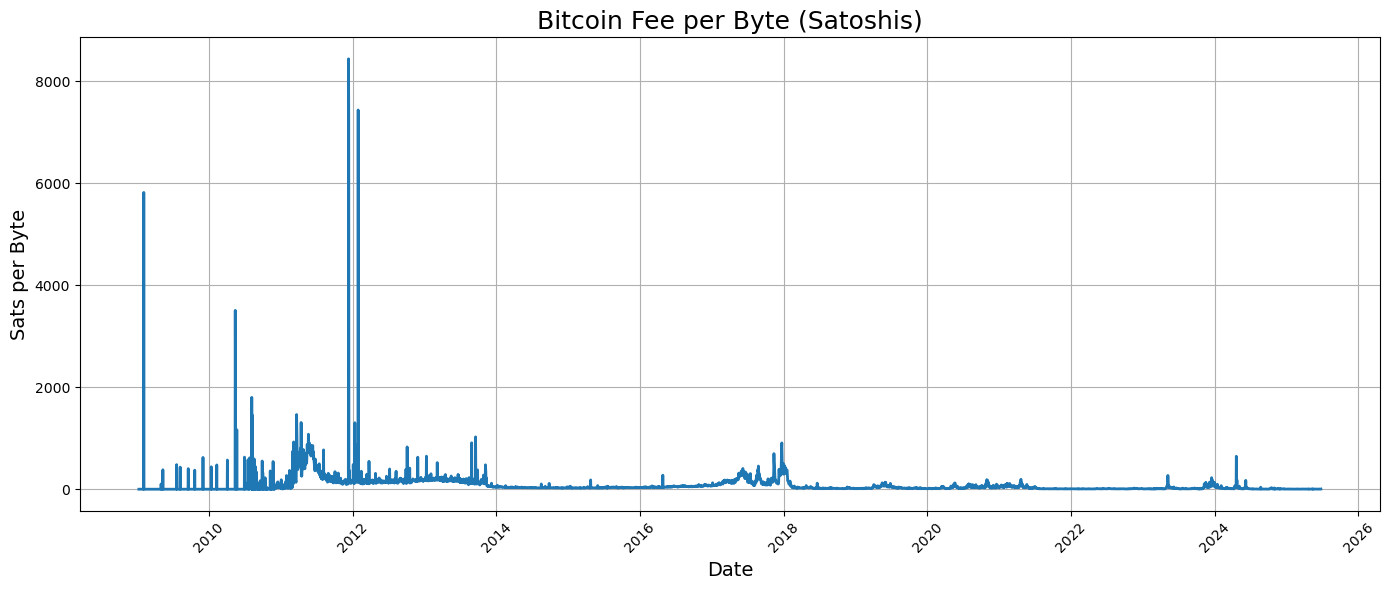

In [3]:
# Convert units to sats/byte
plot_df = fee_df[["FeeByteMeanNtv"]].dropna().copy()
plot_df["FeeByteMeanNtv"] *= 1e8  # Convert BTC → sats

# Create figure and axis
plt.figure(figsize=(14, 6))
sns.lineplot(data=plot_df, x=plot_df.index, y="FeeByteMeanNtv", linewidth=2.0)

# Aesthetic improvements
plt.title("Bitcoin Fee per Byte (Satoshis)", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sats per Byte", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

# Save the plot
plt.savefig("../results/plots/coinmetrics_fees.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

### Insights From Historical Fee Trends: 
Bitcoin fee rates have exhibited extreme volatility in early years (2009–2013), with sporadic spikes reaching over 8000 sats/byte. Post-2014, the fee landscape appears more stable, but periodic congestion events still emerge—particularly around market cycles in 2017 and 2021. This underscores the need for models that handle both long quiet periods and abrupt fee surges.

## 3. Distribution of Fee Rates
To examine the overall structure of fee levels over the past 15 years, we visualize the distribution of mean fee rates per byte (in satoshis). This histogram highlights the skewed nature of fee dynamics, with occasional spikes during congestion periods.

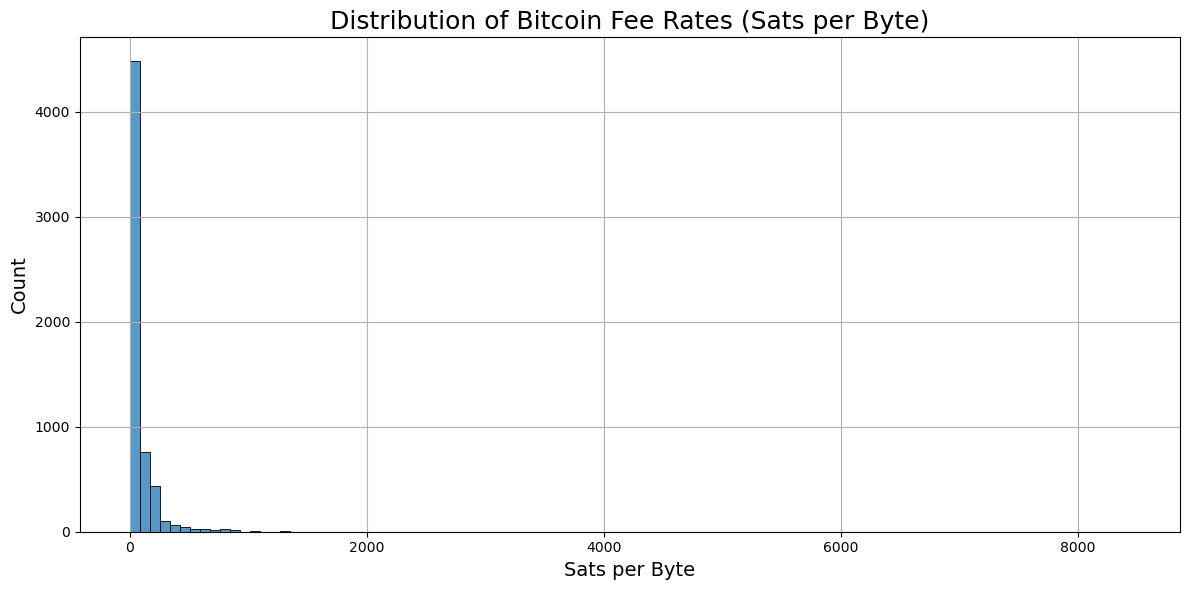

In [4]:
# Convert to sats and drop NaNs
fee_sats = fee_df["FeeByteMeanNtv"].dropna() * 1e8

# Plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(fee_sats, bins=100, kde=False)

# Aesthetic tweaks
plt.title("Distribution of Bitcoin Fee Rates (Sats per Byte)", fontsize=18)
plt.xlabel("Sats per Byte", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.grid(True)

# Show plot
plt.show()

### Insights From Fee Rate Distribution:
The distribution of historical fee rates is highly right-skewed, with the majority of values concentrated below 200 sats/byte. However, the presence of extreme outliers—reaching several thousand sats/byte—reflects rare but severe congestion events. This skewness emphasizes the importance of using robust statistical techniques and loss functions that are not overly sensitive to extreme values.

## 4. Identifying Local Fee Spikes
To explore short-term volatility within each year, we flag days when the fee per byte exceeds the 95th percentile of that year's distribution. This binary time series highlights high-fee events driven by congestion or demand surges, helping us understand the bursty nature of Bitcoin fee dynamics.

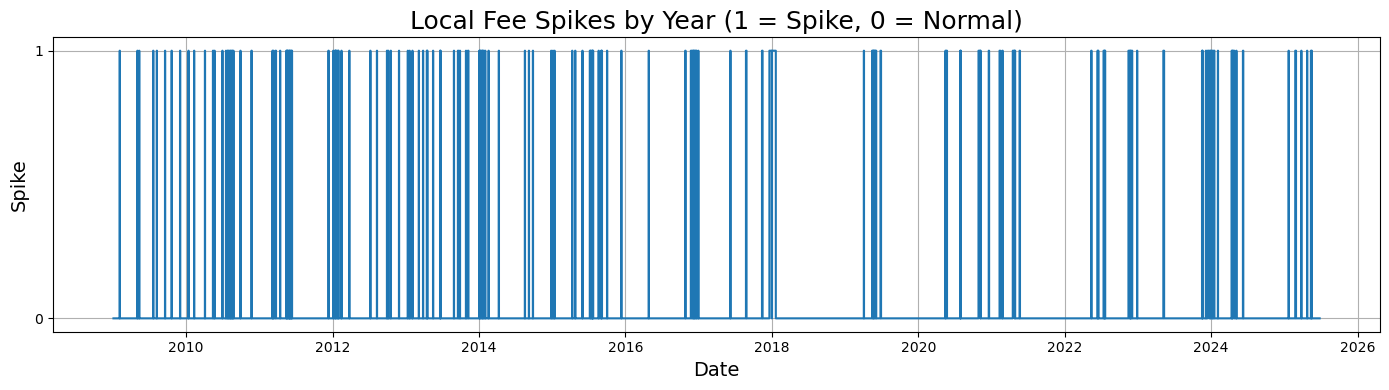

In [5]:
# Create a Year column
fee_df["Year"] = fee_df.index.year

# Group by year and apply a local 95th percentile threshold
def local_spike_mask(group):
    local_thresh = group["FeeByteMeanNtv"].quantile(0.95)
    return (group["FeeByteMeanNtv"] > local_thresh).astype(int)

# Apply spike detection
fee_df["FeeSpikeLocal"] = fee_df.groupby("Year").apply(local_spike_mask).reset_index(level=0, drop=True)

plt.figure(figsize=(14, 4))
sns.lineplot(data=fee_df, x=fee_df.index, y="FeeSpikeLocal", drawstyle="steps-post")

plt.title("Local Fee Spikes by Year (1 = Spike, 0 = Normal)", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Spike", fontsize=14)
plt.yticks([0, 1])
plt.tight_layout()
plt.grid(True)
plt.show()

### Insights From Local Spike Detection:
Local spike detection reveals that fee surges occur almost every year, often in short-lived bursts. These episodes appear irregular and sporadic, suggesting that fee volatility is driven by unpredictable, high-demand events rather than seasonal cycles. This observation supports the need for flexible forecasting models capable of detecting regime shifts or rare congestion periods.

## 5. Inter-Spike Interval Distribution
To assess whether high-fee events occur randomly over time, we calculate the number of days between consecutive local spikes. If the resulting interarrival times follow an exponential distribution, it could suggest a memoryless (Poisson) process. As shown below, the distribution is right-skewed but does not cleanly match the exponential form—hinting that fee spikes may exhibit some temporal structure or clustering.

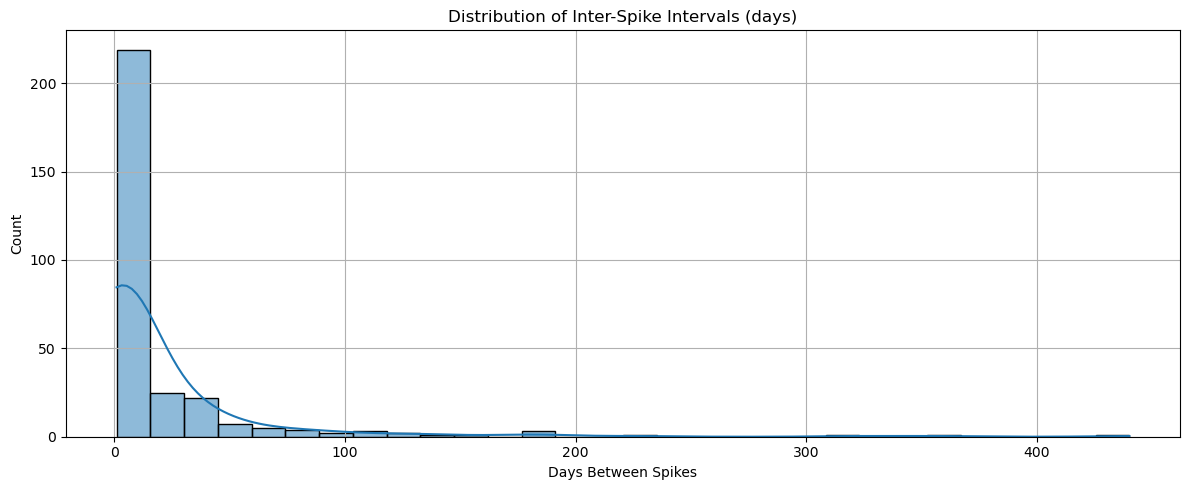

In [6]:
# Extract spike dates
spike_dates = fee_df[fee_df["FeeSpikeLocal"] == 1].index

# Compute inter-spike intervals (in days)
inter_spike_deltas = spike_dates.to_series().diff().dropna().dt.days

plt.figure(figsize=(12, 5))
sns.histplot(inter_spike_deltas, bins=30, kde=True)

plt.title("Distribution of Inter-Spike Intervals (days)")
plt.xlabel("Days Between Spikes")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/plots/coinmetrics_interspike_dist.png", dpi=300, bbox_inches="tight")
plt.show()

### Insights from Inter-Spike Interval Analysis:
Inter-spike intervals are heavily right-skewed, with most fee spikes occurring within short gaps of less than 30 days. However, a long tail of rarer, widely spaced spikes suggests that congestion events do not arrive at regular intervals. This irregularity challenges fixed-horizon models and motivates probabilistic approaches to capture bursty, memoryless patterns.

## 6. Testing for Poisson Behavior
To formally assess whether fee spikes follow a Poisson process, we fit an exponential distribution to the inter-spike intervals using maximum likelihood estimation. We then apply the Kolmogorov–Smirnov (K-S) test:

In [7]:
# Fit exponential distribution (MLE)
lambda_hat = 1 / inter_spike_deltas.mean()

# Run Kolmogorov–Smirnov test
ks_stat, p_value = kstest(inter_spike_deltas, 'expon', args=(0, 1/lambda_hat))

print(f"Estimated lambda: {lambda_hat:.4f}")
print(f"K-S Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value > 0.05:
    print("✅ Cannot reject H0: Intervals are consistent with exponential → Poisson process plausible.")
else:
    print("❌ Reject H0: Intervals deviate from exponential → Poisson process questionable.")

Estimated lambda: 0.0501
K-S Statistic: 0.4544
P-value: 0.0000
❌ Reject H0: Intervals deviate from exponential → Poisson process questionable.


### Insight from K-S Test: 
The K–S test rejects the exponential assumption (p < 0.001), indicating that fee spike intervals deviate from a Poisson process. This suggests that memoryless models may be insufficient, and autoregressive structures (e.g., ARIMA, LSTM) might better capture the dynamics.

## 7. Summary: Testing for Patterns in Fee Spikes

To investigate whether congestion-driven fee spikes exhibit recognizable patterns or arrive randomly, we analyzed over 15 years of historical Bitcoin fee data using the following steps:

- **Spike Detection**:  
  Flagged high-fee days by applying a rolling yearly 95th percentile threshold on daily fee rates.

- **Interval Extraction**:  
  Measured the number of days between consecutive spike events to create an inter-spike interval distribution.

- **Distribution Fitting**:  
  Fit an poisson distribution to these intervals using Maximum Likelihood Estimation (MLE) to model randomness.

- **Goodness-of-Fit Test**:  
  Conducted a Kolmogorov–Smirnov (K–S) test to assess whether the observed intervals follow a memoryless (exponential) process.

- **Result**:  
  The K–S test **rejected** the null hypothesis (p-value < 0.05), indicating that congestion events do **not(()) occur randomly and may follow more structured, time-dependent patterns.

## 8. Key Takeaway

Bitcoin fee spikes do **not** occur independently or at a constant rate. This challenges the assumption of a Poisson-like arrival process and suggests that spikes are shaped by time-varying, market-driven, or cyclical dynamics—underscoring the importance of **time-sensitive, non-memoryless** forecasting approaches.

# II. EDA on Our Mempool Transformed Time Series Dataset

The dataset provided to us is originally formed by taking the raw mempool data and transforming it into a time series format. This transformation allows us to analyze the data in a structured way and sequential order, capturing the temporal dynmaicss that are relevant for forecasting Bitcoin transaction fees.

## 1. Load Dataset

In [8]:
df = pd.read_parquet('../data/raw/mar_5_may_12.parquet')

df.head()

,timestamp,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_550_600,mempool_fee_histogram_bin_600_650,mempool_fee_histogram_bin_650_700,mempool_fee_histogram_bin_700_750,mempool_fee_histogram_bin_750_800,mempool_fee_histogram_bin_800_850,mempool_fee_histogram_bin_850_900,mempool_fee_histogram_bin_900_950,mempool_fee_histogram_bin_950_1000,mempool_fee_histogram_bin_1000_plus
0,1741140733,2210077.0,997916.50,556.0,1615739.0,1.300082,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1741140881,2131827.0,997874.25,1030.0,2077770.0,1.300139,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1741141182,1986259.0,997882.00,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1741141481,1814202.0,997958.25,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1741141782,1604116.0,997937.50,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.shape

(19799, 83)

## 2. Raw Data Description
The dataset is comprised of Mar. 5 - May. 12, 2025 hourly time series data with 19799 rows × 83 columns (with primarily floating values). The dataset contains the following categories of features:

![Raw Data Description](../img/data_description.png)

## 3. Data Cleaning

For data cleaning, we check for any abnormalities such as missing values, duplicate rows, and zero-valued columns. We also ensure that the data types are appropriate for analysis.

### 3.1 Remove Zero-Valued Columns

To reduce dimensionality and remove irrelevant features, we dropped histogram bin columns whose values were all zero across the dataset. These columns offer no variance or predictive value.

In [10]:
# Filter columns that start with "mempool_fee_histogram_bin_"
hist_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]

# Identify columns where all values are 0.0
zero_hist_cols = [col for col in hist_cols if (df[col] == 0.0).all()]

print("Histogram columns with only 0 float values:")
print(zero_hist_cols)
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

df.drop(columns=cols_to_drop, inplace=True)

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


In [11]:
df.shape

(19799, 68)

### 3.2 Missing Values Check

We first examine the dataset structure and basic statistics to verify the completeness of the data and highlights potential issues that may impact feature distributions or modeling later on. 
 
We find that:
- All columns are of type `float64` besides timestamp, which is in `int64`.
- Only 5 columns (`mempool_blocks_*`) have a single missing value each out of 19,799 entries — likely caused by transient API retrieval issues. These can be safely ignored or imputed with simple techniques.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19799 entries, 0 to 19798
Data columns (total 68 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   timestamp                                 19799 non-null  int64  
 1   mempool_blocks_blockSize                  19798 non-null  float64
 2   mempool_blocks_blockVSize                 19798 non-null  float64
 3   mempool_blocks_nTx                        19798 non-null  float64
 4   mempool_blocks_totalFees                  19798 non-null  float64
 5   mempool_blocks_medianFee                  19798 non-null  float64
 6   recommended_fee_fastestFee                19799 non-null  float64
 7   recommended_fee_halfHourFee               19799 non-null  float64
 8   recommended_fee_hourFee                   19799 non-null  float64
 9   recommended_fee_economyFee                19799 non-null  float64
 10  recommended_fee_minimumFee        

### 3.3 Abnormalities Check
Then, we check for any abnormalities in the dataset, such as unexpected data types or unmeaningful values. This ensures that the dataset is clean and ready for analysis. 

We see that: 
- Several upper-range fee histogram bins (e.g., `mempool_fee_histogram_bin_200_250`, `bin_250_300`) consistently contain low or zero values, suggesting limited transaction volume in those fee ranges.
- There were anomalies in the `price_USD` feature (Bitcoin price in USD), where the minimum value is -1, which is not a valid price and likely indicates a placeholder or error in data collection. We specifically put focus to this feature as it is the most commonly referenced and stable fiat benchmark for Bitcoin.

Therefore, we further investigate this issue before proceeding with distributional analysis of each feature.

In [13]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
timestamp,19799.0,1.744110e+09,1.714687e+06,1.741141e+09,1.742625e+09,1.744110e+09,1.745595e+09,1.747080e+09
mempool_blocks_blockSize,19798.0,1.607888e+06,3.942233e+05,7.501000e+03,1.515908e+06,1.629784e+06,1.746011e+06,3.914498e+06
mempool_blocks_blockVSize,19798.0,9.509414e+05,1.681787e+05,4.367250e+03,9.979165e+05,9.979565e+05,9.979835e+05,9.979998e+05
mempool_blocks_nTx,19798.0,2.764852e+03,1.178013e+03,1.500000e+01,1.904250e+03,2.948500e+03,3.651000e+03,6.408000e+03
mempool_blocks_totalFees,19798.0,4.079025e+06,3.701775e+06,1.565800e+04,2.116156e+06,3.212682e+06,4.890065e+06,8.107809e+07
...,...,...,...,...,...,...,...,...
mempool_fee_histogram_bin_95_100,19799.0,1.280908e+01,8.060486e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.217400e+04
mempool_fee_histogram_bin_100_150,19799.0,1.183340e+03,1.225039e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.117370e+05
mempool_fee_histogram_bin_150_200,19799.0,2.226688e+02,3.703482e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.893900e+04
mempool_fee_histogram_bin_200_250,19799.0,7.075837e+01,2.137194e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.550100e+04


Based on our further investigation on the price abnormalities, we conclude the following: 
- Out of 19,799 rows, only 4 entries in the price_USD column have a value of -1.
- This likely indicates missing or invalid price data during those specific time periods.
- Given the minimal impact, these rows can either be dropped or handled using simple imputation.

In [14]:
# Anomaly detection for -1 values in 'price_USD'
anomaly_prices = df[df['price_USD'] == -1]
anomaly_count = anomaly_prices.shape[0]
anomaly_timestamps = anomaly_prices.index 

print(f"Number of -1 values in 'price_USD': {anomaly_count}")
print(f"Timestamps (or indices) with -1 values: {anomaly_timestamps}")

Number of -1 values in 'price_USD': 4
Timestamps (or indices) with -1 values: Index([9736, 9737, 9738, 10831], dtype='int64')


### 3.4 Convert Timestamp and Set Index

Finally, we ensured that the `timestamp` column is properly converted and set as the DataFrame index. This enables correct alignment for downstream time series modeling

In [15]:

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)

After setting `timestamp` as the index, we verify the dataset's overall time span and sampling interval to ensure temporal consistency and proper alignment for time series analysis. The most frequent sampling interval is **5 minutes**, with minor irregularities likely due to API extraction. To ensure compatibility with time series models, we will apply reindexing and interpolation in preprocessing so that timestamps are evenly spaced and the dataset is model-ready.

In [16]:
print(f"Dataset shape: {df.shape}")
print("Start:", df.index.min())
print("End:", df.index.max())
print("Frequency mode:", df.index.to_series().diff().mode())

Dataset shape: (19799, 67)
Start: 2025-03-05 02:12:13
End: 2025-05-12 19:59:41
Frequency mode: 0   0 days 00:05:00
Name: timestamp, dtype: timedelta64[ns]


## 4. In-Depth Features Analsysis
To build accurate forecasting models, it's essential to understand the key features involved — what they represent, how they're measured, and how they're distributed. This section summarizes the core variables in the dataset and prepares for deeper distributional analysis.

### 4.1 Summary Table of Key Features
This section provides a summary of key features in the dataset, categorized by purpose. Each feature is briefly described to support interpretability and guide downstream analysis.

We focus on variables related to mempool activity, projected block structure, fee rates, difficulty adjustment, and Bitcoin market conditions. Histogram bin variables (e.g., `mempool_fee_histogram_bin_1_2`) are grouped and interpreted based on fee range density.

| Feature                                  | Description                                            |
|:-----------------------------------------|:-------------------------------------------------------|
| mempool_blocks_blockSize                 | Total raw block size of pending transactions (bytes)   |
| mempool_blocks_blockVSize                | Virtual size of pending block (vBytes)                 |
| mempool_blocks_nTx                       | Number of transactions in the estimated next block     |
| mempool_blocks_totalFees                 | Total fees expected in next block (satoshis)           |
| mempool_blocks_medianFee                 | Median fee rate in the next block (sats/vB)            |
| recommended_fee_fastestFee               | Recommended fee for fastest confirmation (sats/vB)     |
| recommended_fee_halfHourFee              | Recommended fee for confirmation within 30 mins        |
| recommended_fee_hourFee                  | Recommended fee for confirmation within 1 hour         |
| recommended_fee_economyFee               | Recommended low-priority fee (slower confirmation)     |
| recommended_fee_minimumFee               | Minimum fee needed to enter the mempool                |
| mempool_count                            | Number of unconfirmed transactions in the mempool      |
| mempool_vsize                            | Total virtual size of mempool (vBytes)                 |
| mempool_total_fee                        | Total fee volume of mempool (sats)                     |
| difficulty_adjustment_progressPercent    | Progress toward next difficulty adjustment (%)         |
| difficulty_adjustment_difficultyChange   | Expected difficulty change (%)                         |
| difficulty_adjustment_remainingBlocks    | Blocks left until next difficulty adjustment           |
| difficulty_adjustment_remainingTime      | Estimated time until difficulty adjustment (sec)       |
| difficulty_adjustment_previousTime       | Time taken for the previous difficulty epoch (sec)     |
| difficulty_adjustment_nextRetargetHeight | Height at which next difficulty retarget occurs        |
| difficulty_adjustment_timeAvg            | Average time between blocks in the current epoch (sec) |
| difficulty_adjustment_adjustedTimeAvg    | Adjusted average block time considering skew           |
| difficulty_adjustment_timeOffset         | Time offset vs. expected block production              |
| difficulty_adjustment_expectedBlocks     | Expected blocks per difficulty period                  |
| price_USD                                | Bitcoin market price in USD                            |
| price_EUR                                | Bitcoin market price in EUR                            |
| price_GBP                                | Bitcoin market price in GBP                            |
| price_CAD                                | Bitcoin market price in CAD                            |
| price_CHF                                | Bitcoin market price in CHF                            |
| price_AUD                                | Bitcoin market price in AUD                            |
| price_JPY                                | Bitcoin market price in JPY                            |
| mempool_fee_histogram_bin_               | Each mempool_fee_histogram_bin_* feature represents the number of transactions in the mempool whose fee rate falls within a specific sats/vB range (e.g., bin_1_2 means 1–2 sats/vB).|

### 4.2 Mempool Block Features

This section examines the distribution of mempool block features, such as transaction count, block size, and expected fees. These variables help characterize network demand and congestion levels.

Each histogram below shows the distribution of a `mempool_blocks_` feature. The goal is to understand variability, detect skewness, and assess whether transformation may be beneficial.

> **Note:** The plot for `mempool_blocks_blockVSize` uses a log-scaled Y-axis to better visualize extremely skewed frequencies.  
> This feature shows very low variance — most values are tightly clustered near ~998,000.  
> A log scale helps reveal subtle differences and avoids a visually flat histogram.

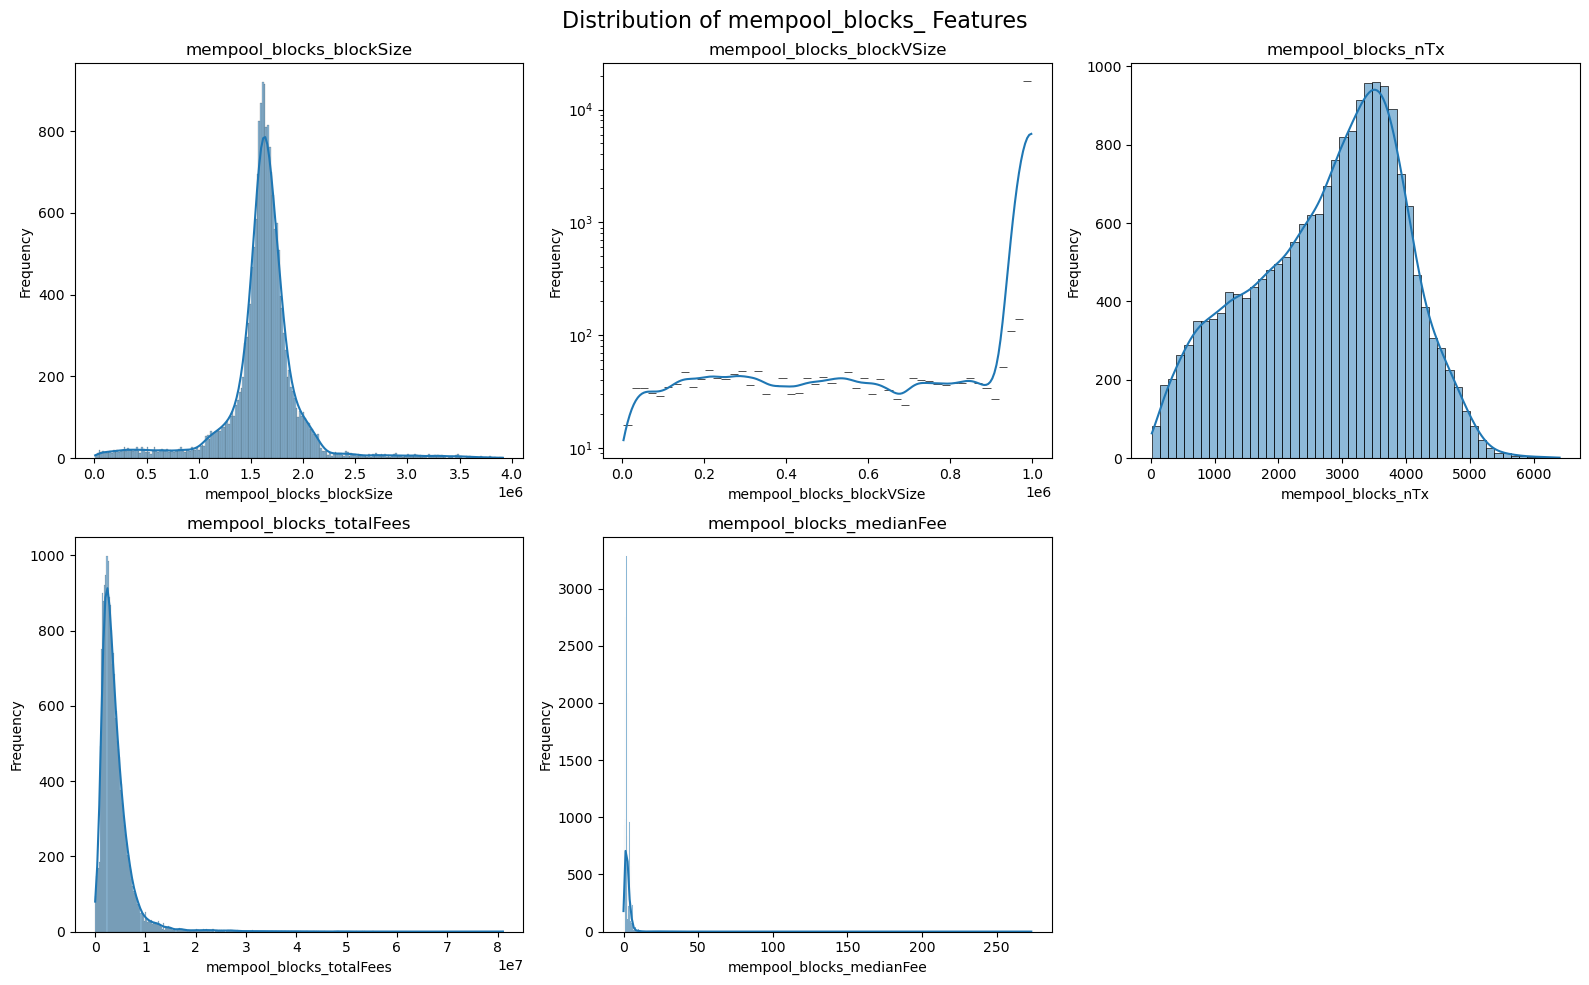

In [17]:
special_cols = ["mempool_blocks_blockVSize"]
plot_feature_group(df, "mempool_blocks_", special_cols=special_cols)

#### Key Insights Mempool Block Features:
- Most `mempool_blocks_` features are continuous and non-negative.  
- Some variables (e.g., `mempool_blocks_totalFees`, `mempool_blocks_medianFee`) exhibit heavy right skew due to occasional fee spikes.  
- These patterns reflect the bursty nature of blockchain activity and may motivate log transformation for variance stabilization in modeling.

### 4.3 Mempool State Features
The mempool state features describe the overall size and volume of pending transactions in the Bitcoin network.

These variables are important indicators of network congestion and transaction pressure. Their distributional characteristics may influence model selection or transformations.


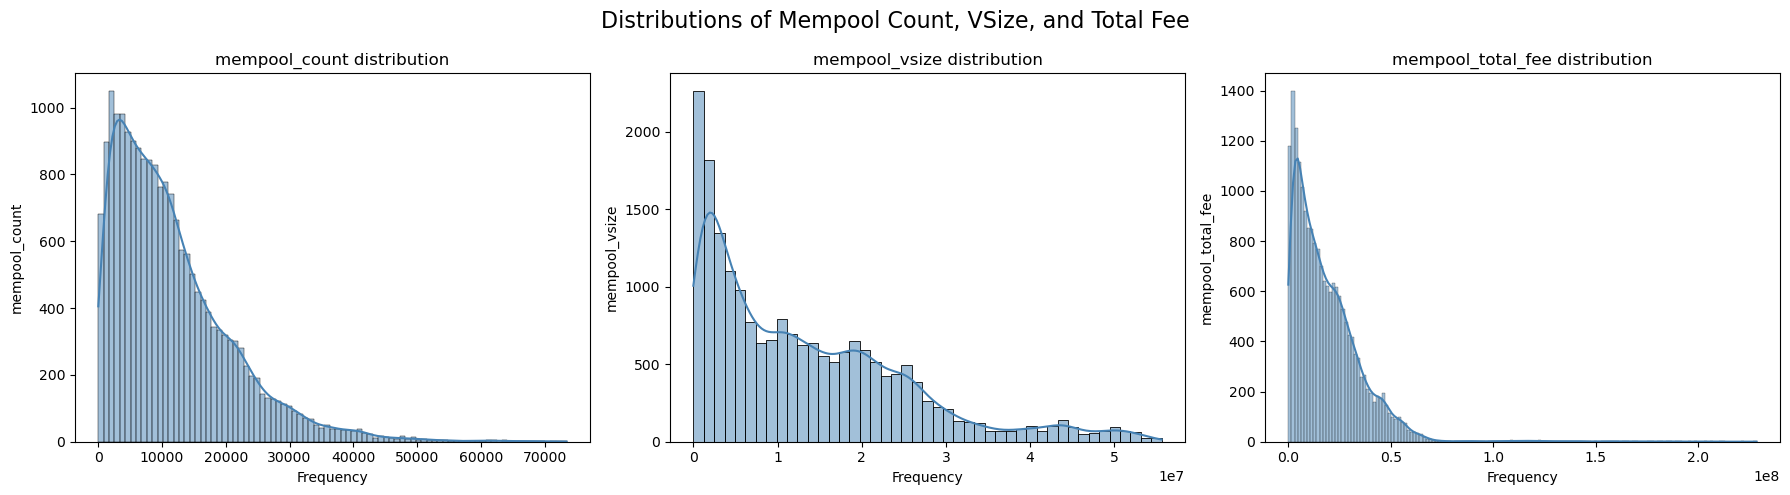

In [18]:
features = ["mempool_count", "mempool_vsize", "mempool_total_fee"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, feature in enumerate(features):
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"{feature} distribution")
    axes[i].set_ylabel(feature)
    axes[i].set_xlabel("Frequency")

fig.suptitle("Distributions of Mempool Count, VSize, and Total Fee", fontsize=16)
plt.tight_layout()
plt.show()

#### Key Insights from Mempool State Features:
- `mempool_count`, `mempool_vsize`, and `mempool_total_fee` all exhibit strong right-skewness with long tails.
- A log transformation or outlier trimming may help stabilize variance and improve model fit.


### 4.4 Difficulty Adjustment Features
This section explores features related to Bitcoin's mining difficulty adjustment process. These variables help track progress, timing, and expected block targets across difficulty epochs. Understanding their distributions can inform how temporal or periodic structures might influence modeling.

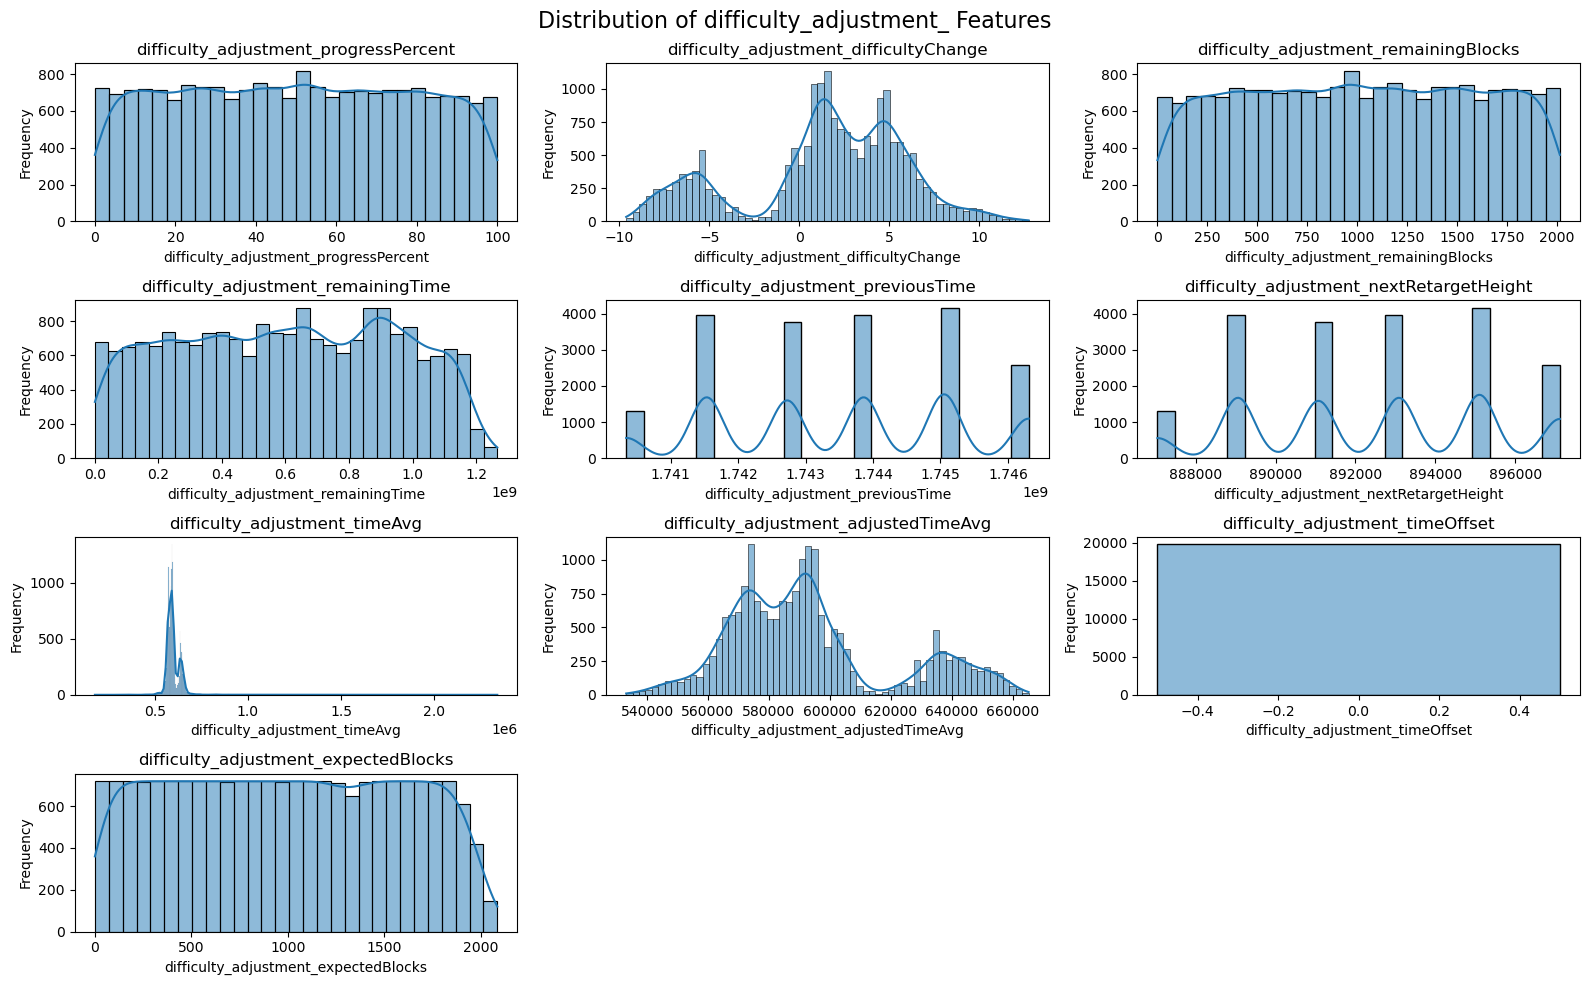

In [19]:
plot_feature_group(df, "difficulty_adjustment_")

#### Key Insights from Difficulty Adjustment Features:

- Features like `difficulty_adjustment_progressPercent` and `difficulty_adjustment_expectedBlocks` appear roughly uniform or multi-modal, reflecting variability across epochs.
- Discrete spikes in `previousTime` and `nextRetargetHeight` correspond to deterministic retarget boundaries—these may serve as useful epoch markers.

### 4.5 BTC Price Features
We analyze the distribution of Bitcoin prices in multiple currencies to evaluate their variability and potential need for transformation. These features serve as external market indicators and may contribute to modeling performance if aligned with fee dynamics.

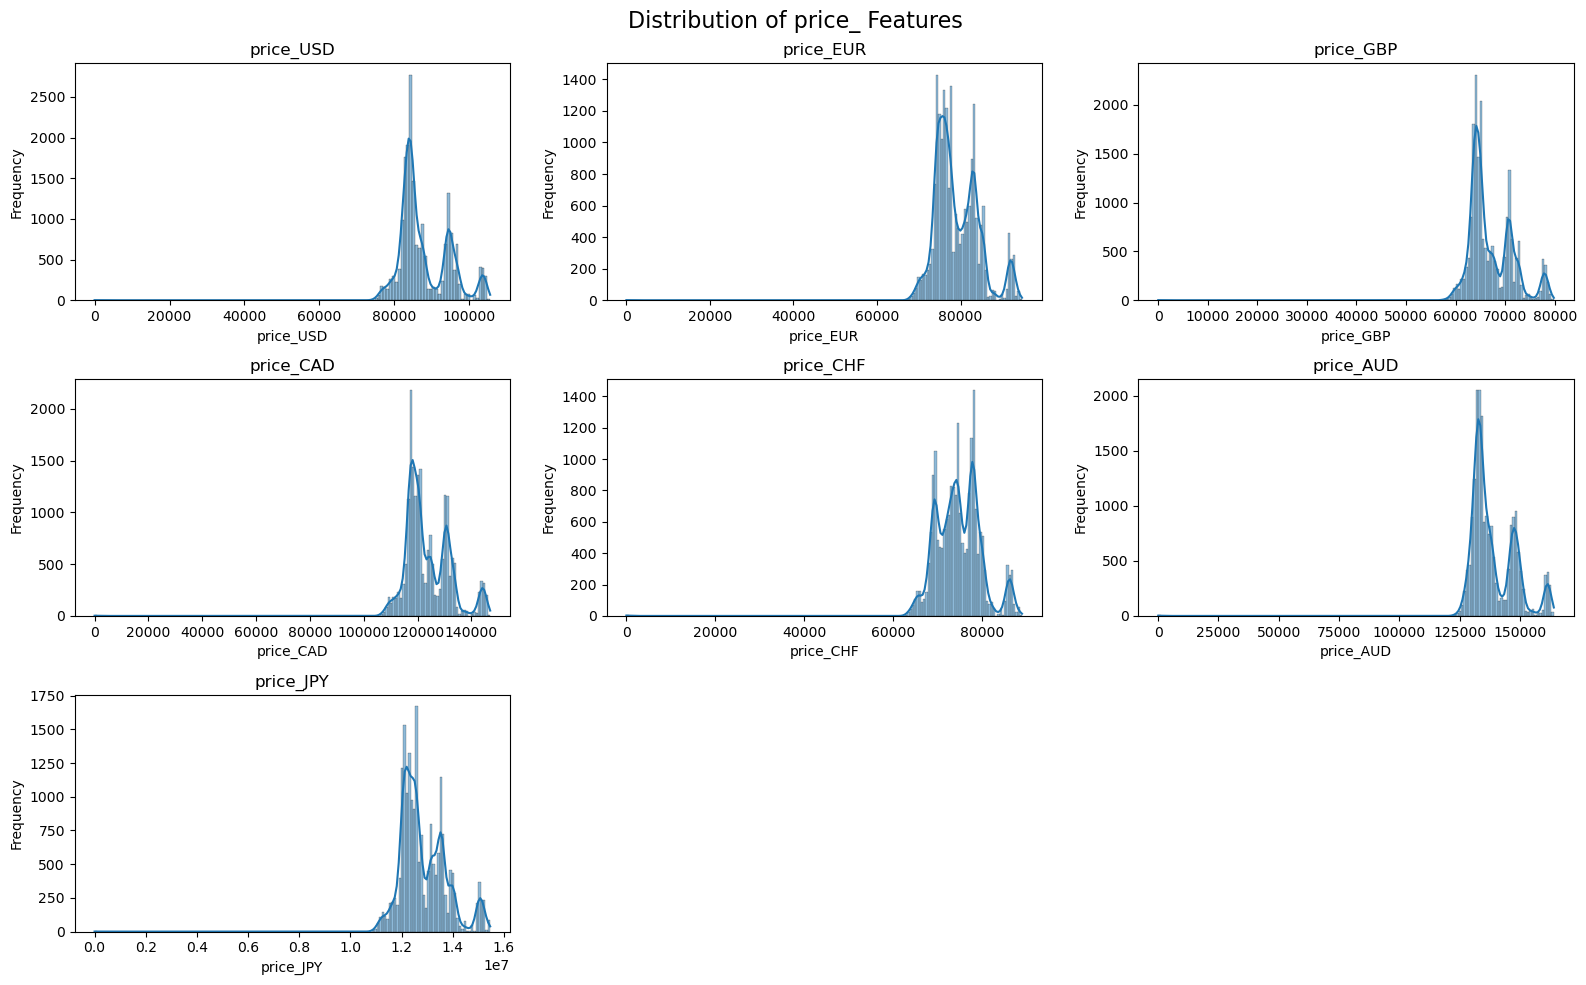

In [20]:
plot_feature_group(df, "price_")

#### Key Insights from BTC Price Features:
- All currency prices (`price_USD`, `price_EUR`, ...) cluster within narrow ranges and exhibit similar multi-modal patterns.
- This consistency reflects synchronized market behavior across currencies.
- Price features are relatively stable and can be used as external covariates without transformation.

### 4.6 Histogram Binned Counts

Histogram bin features summarize how transactions are distributed across fee ranges. These bins reflect user behavior under different network conditions and can highlight preferred fee levels or congestion thresholds.

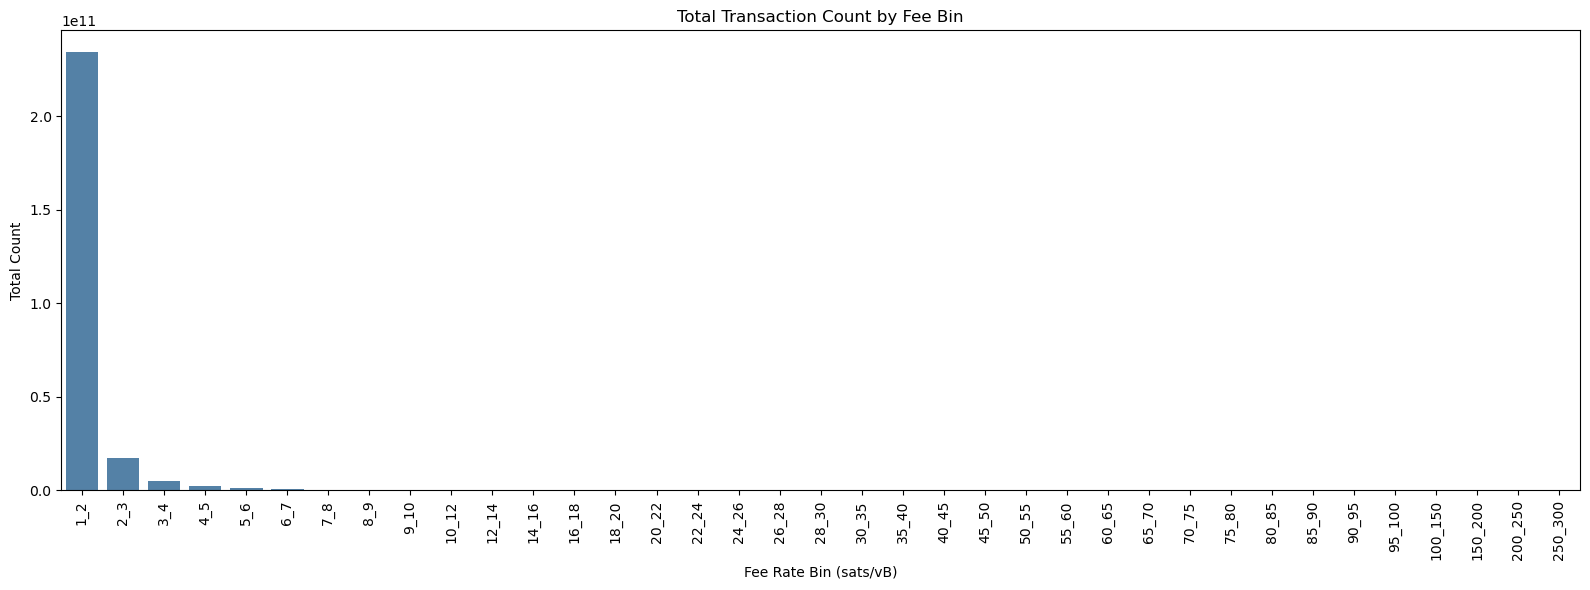

In [21]:
fee_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()
def extract_start(bin_name):
    return float(bin_name.split("_")[-2])
total_per_bin = total_per_bin.sort_values(key=lambda x: [extract_start(c) for c in x.index])
bin_labels = [col.replace("mempool_fee_histogram_bin_", "") for col in total_per_bin.index]
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=total_per_bin.values, color="steelblue")
plt.xticks(rotation=90)
plt.title("Total Transaction Count by Fee Bin")
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()


To make the binned fee counts more readable across a wide dynamic range given the highly right-skewed distributions, we apply a log transformation to the total count in each fee bin. This helps reveal patterns in the mid-to-high fee ranges that are otherwise overshadowed by the extreme skew toward low-fee transactions. This transformation may guide bin grouping or scaling decisions for downstream modeling.

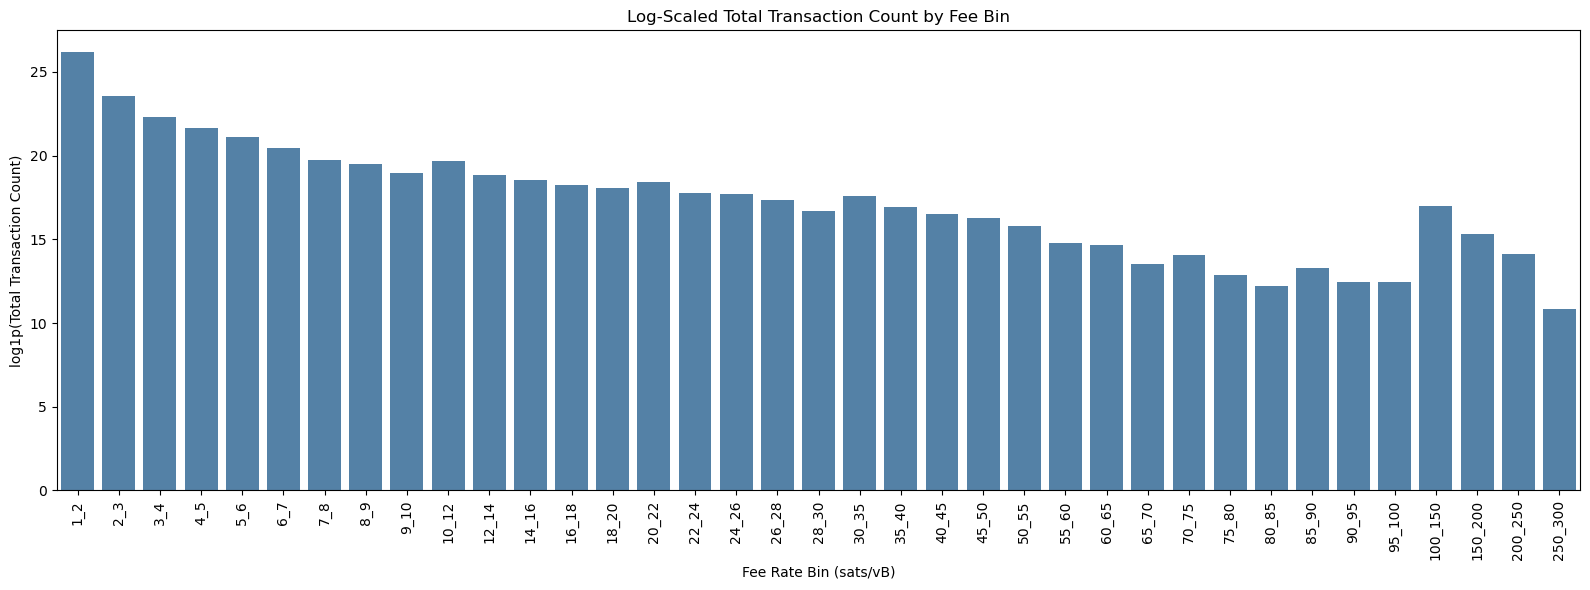

In [22]:
# Sum total transaction counts for each fee bin
fee_cols = [c for c in df.columns if c.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()

# Extract numeric labels for plotting
bin_labels = [c.replace("mempool_fee_histogram_bin_", "") for c in total_per_bin.index]

# Apply log1p transformation to counts
log_counts = np.log1p(total_per_bin)

# Plot the log-scaled counts
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=log_counts.values, color="steelblue")
plt.xticks(rotation=90)
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("log1p(Total Transaction Count)")
plt.title("Log-Scaled Total Transaction Count by Fee Bin")
plt.tight_layout()
plt.show()


More importantly, to better quantify the fee rate distribution, we calculate the relative proportion of transaction counts in each fee bin. This reveals where network activity is most concentrated and informs downstream feature engineering.

In [23]:
# Calculate the proportion of each bin's count relative to the total count
total_count = total_per_bin.sum()
bin_proportions = total_per_bin / total_count * 100
bin_proportions.head()

mempool_fee_histogram_bin_1_2    88.920292
mempool_fee_histogram_bin_2_3     6.607297
mempool_fee_histogram_bin_3_4     1.889410
mempool_fee_histogram_bin_4_5     0.970463
mempool_fee_histogram_bin_5_6     0.553361
dtype: float64

#### Key Insights from Histogram Binned Counts:
- Roughly 88.9% of all transactions fall into the 1–2 sats/vB bin; including 2–3 sats/vB brings the cumulative share above 95.5%.
- Bins above 5 sats/vB are extremely rare (**0.6%**) and could be aggregated or treated as “other” in downstream modeling to reduce sparsity.
- After applying the `log₁₀` transform, the dominance of the 1–2 sats/vB bin remains, but the decline across higher bins appears smoother.
- This reveals that although the vast majority of transactions occur at very low fees, there is meaningful activity extending up to around 20 sats/vB.


## 5. Pairwise Correlation Analysis
To understand relationships between features, we compute pairwise correlations using the Pearson method. This helps identify redundant predictors, potential multicollinearity issues, and clusters of strongly related variables that may warrant further investigation.

### 5.1 Group-wise Feature Correlation Analysis
We analyze within-group correlations to detect redundancy or identify clusters of strongly related features before modeling. We are using Spearman correlation to capture monotonic relationships, which is more robust to outliers and non-linear patterns.

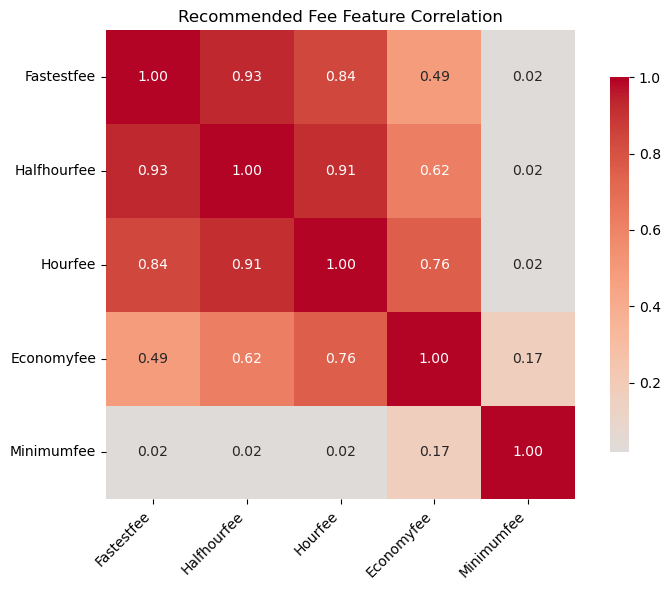

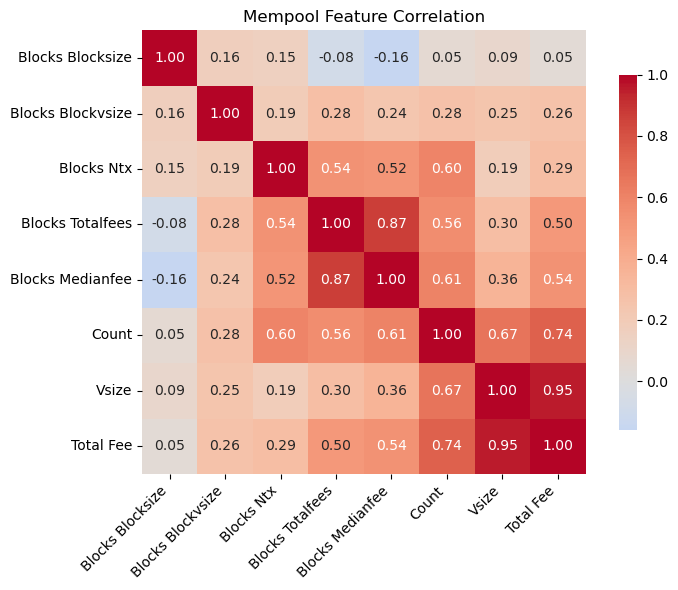

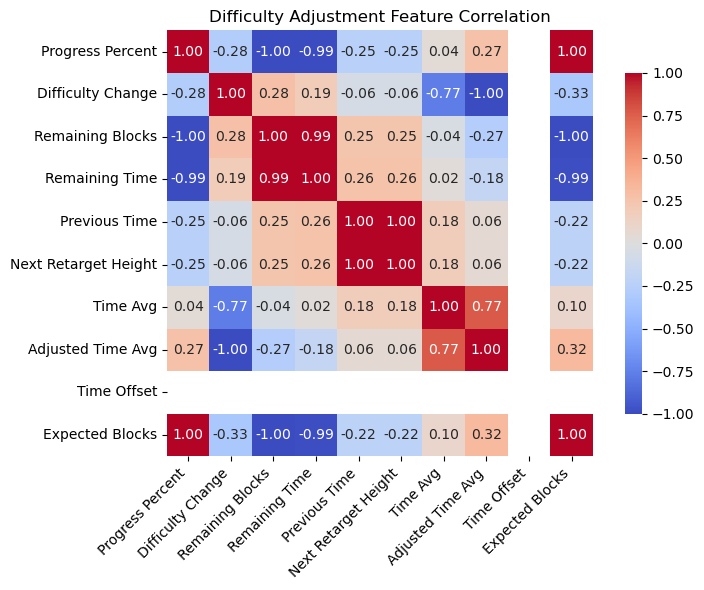

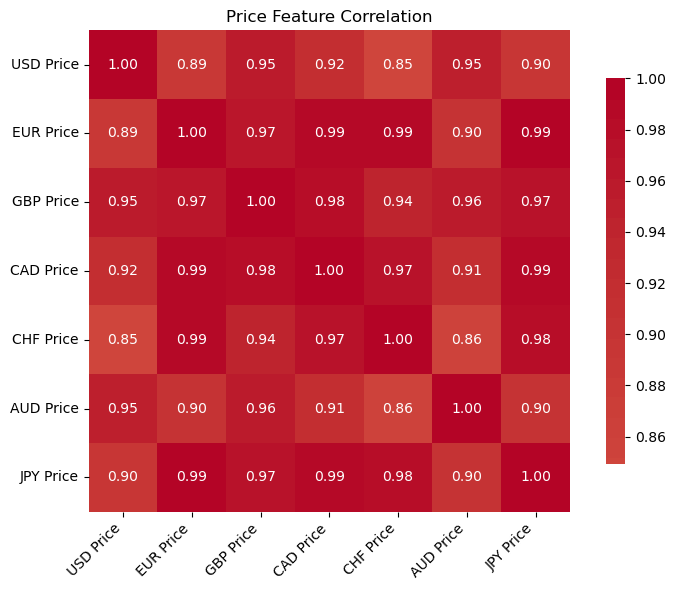

In [24]:
group_prefixes = {
    "recommended_fee": "recommended_fee_",
    "mempool": "mempool_",
    "difficulty_adjustment": "difficulty_adjustment_",
    "price": "price_"
}

exclude = ["mempool_fee_histogram_"]

friendly_names = {
    "difficulty_adjustment_progressPercent": "Progress Percent",
    "difficulty_adjustment_difficultyChange": "Difficulty Change",
    "difficulty_adjustment_remainingBlocks": "Remaining Blocks",
    "difficulty_adjustment_remainingTime": "Remaining Time",
    "difficulty_adjustment_previousTime": "Previous Time",
    "difficulty_adjustment_nextRetargetHeight": "Next Retarget Height",
    "difficulty_adjustment_timeAvg": "Time Avg",
    "difficulty_adjustment_adjustedTimeAvg": "Adjusted Time Avg",
    "difficulty_adjustment_timeOffset": "Time Offset",
    "difficulty_adjustment_expectedBlocks": "Expected Blocks",
    "price_USD": "USD Price",
    "price_EUR": "EUR Price",
    "price_GBP": "GBP Price",
    "price_CAD": "CAD Price",
    "price_CHF": "CHF Price",
    "price_AUD": "AUD Price",
    "price_JPY": "JPY Price"
}

for g, p in group_prefixes.items():
    plot_group_correlation(df,
                           group_name=g,
                           prefix=p,
                           exclude_prefixes=exclude,
                           label_map=friendly_names)


#### Key Insights from Group-wise Correlation Analysis:
The correlation heatmaps reveal several key relationships across feature groups:

- **Recommended Fee Group**  
  `fastestFee`, `halfHourFee`, and `hourFee` are highly correlated (p > 0.9), suggesting they capture similar network conditions.  
  In contrast, `economyFee` and `minimumFee` show weaker or no correlation, indicating they may reflect different user behavior (e.g., low-priority transactions).

- **Mempool Group**  
  Features like `mempool_vsize` and `mempool_total_fee` are strongly correlated (p > 0.8), likely due to shared dependence on transaction volume.  
  However, `mempool_blocks_medianFee` is weakly correlated with most others, potentially offering unique information about block-level fee trends.

- **Difficulty Adjustment Group**  
  Many features show perfect positive or negative correlations (e.g., `remainingBlocks` vs. `progressPercent`, r = -1.0), reflecting deterministic relationships from Bitcoin’s difficulty adjustment algorithm.  
  This suggests redundancy within the group and motivates dimensionality reduction (e.g., dropping derived variables).

- **Price Group**  
  All fiat-denominated Bitcoin prices (USD, EUR, GBP, etc.) are highly correlated (p > 0.9), as expected given stable exchange rates.  
  These features are interchangeable unless currency-specific effects are being studied.

### 5.2 Cross-Group Correlation Analysis with Significance Testing

We compute both **Pearson** and **Spearman** correlation matrices for selected congestion-related features to examine their relationships with the target variable `recommended_fee_fastestFee`.

To assess the reliability of these correlations, we also include **p-value checks** to confirm statistical significance.  
This helps ensure that observed correlations are not due to random variation.


In [25]:
corr_features = [
    "recommended_fee_fastestFee",
    "mempool_total_fee",
    "mempool_count",
    "mempool_blocks_nTx",
    "mempool_blocks_blockVSize",
    "difficulty_adjustment_difficultyChange",
    "mempool_blocks_totalFees"
]

label_map = {
    "recommended_fee_fastestFee": "Fastest Fee",
    "mempool_total_fee": "Mempool Total Fee",
    "mempool_count": "Mempool Count",
    "mempool_blocks_nTx": "Next Block # of Transaction",
    "mempool_blocks_blockVSize": "Block vSize",
    "difficulty_adjustment_difficultyChange": "Difficulty Change",
    "mempool_blocks_totalFees": "Next Block Total Fee"
}

# Prepare correlation and p-value matrices
pearson_corr = pd.DataFrame(index=corr_features, columns=corr_features)
pearson_pval = pd.DataFrame(index=corr_features, columns=corr_features)

spearman_corr = pd.DataFrame(index=corr_features, columns=corr_features)
spearman_pval = pd.DataFrame(index=corr_features, columns=corr_features)

for i in corr_features:
    for j in corr_features:
        x = df[i].dropna()
        y = df[j].dropna()
        common_idx = x.index.intersection(y.index)
        if len(common_idx) > 2:
            # Pearson
            r, p = pearsonr(x[common_idx], y[common_idx])
            pearson_corr.loc[i, j] = r
            pearson_pval.loc[i, j] = p
            # Spearman
            r_s, p_s = spearmanr(x[common_idx], y[common_idx])
            spearman_corr.loc[i, j] = r_s
            spearman_pval.loc[i, j] = p_s
            
# Convert to float and rename axes
pearson_corr = pearson_corr.astype(float).rename(index=label_map, columns=label_map)
spearman_corr = spearman_corr.astype(float).rename(index=label_map, columns=label_map)
pearson_pval = pearson_pval.astype(float).rename(index=label_map, columns=label_map)
spearman_pval = spearman_pval.astype(float).rename(index=label_map, columns=label_map)


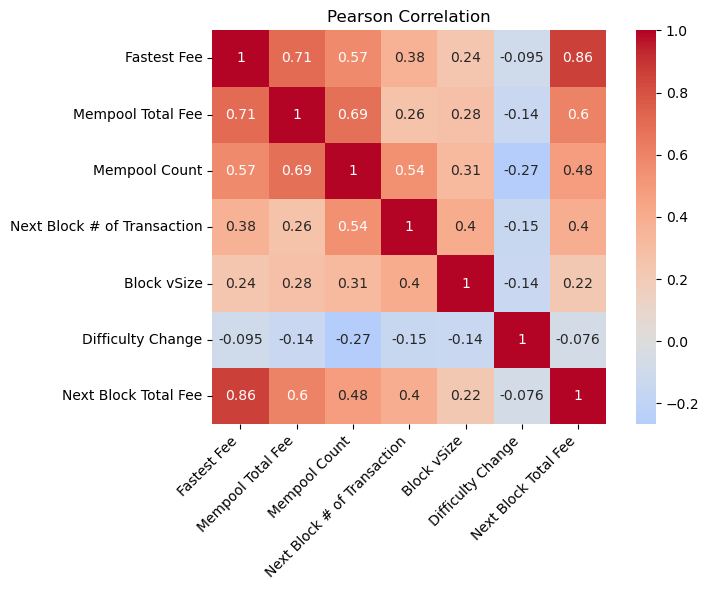

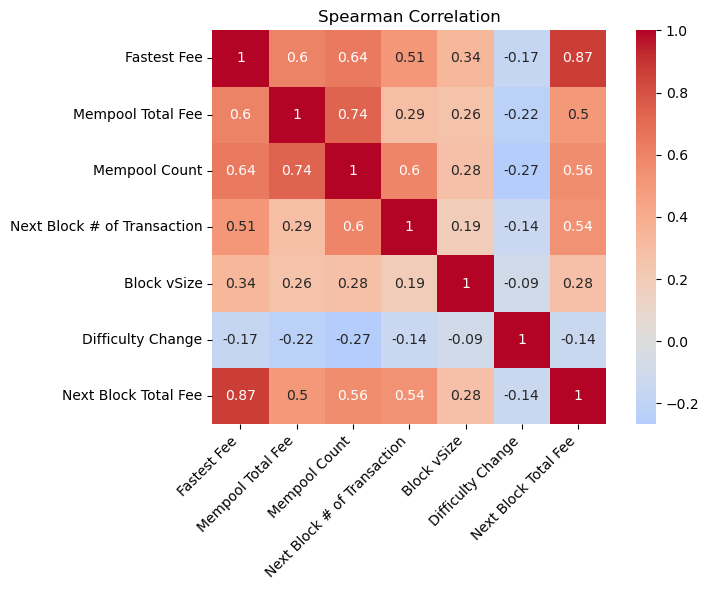

In [26]:
# Pearson correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr.astype(float), annot=True, cmap='coolwarm', center=0, square=True)
plt.xticks(rotation=45, ha='right')
plt.title("Pearson Correlation")
plt.tight_layout()
plt.show()

# Spearman correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr.astype(float), annot=True, cmap='coolwarm', center=0, square=True)
plt.xticks(rotation=45, ha='right')
plt.title("Spearman Correlation")
plt.tight_layout()
plt.show()

In [27]:
# Extract p-values and correlation against target
target = "Fastest Fee"
corr_summary = pd.DataFrame({
    'Pearson_corr': pearson_corr.loc[target],
    'Pearson_p': pearson_pval.loc[target],
    'Spearman_corr': spearman_corr.loc[target],
    'Spearman_p': spearman_pval.loc[target]
})

# Define formatter for p-values
def format_pval(p):
    """
    Formats a p-value for clean table display.

    Parameters:
        p (float or None): The p-value to format.

    Returns:
        str: A string representation of the p-value:
             - "<0.0001" if the value is very small,
             - "NA" if missing,
             - or rounded to 4 decimal places otherwise.
    """
    if pd.isnull(p):
        return "NA"
    elif p < 0.0001:
        return "<0.0001"
    else:
        return f"{p:.4f}"

# Apply formatting
corr_summary_formatted = corr_summary.copy()
corr_summary_formatted["Pearson_corr"] = corr_summary_formatted["Pearson_corr"].round(2)
corr_summary_formatted["Spearman_corr"] = corr_summary_formatted["Spearman_corr"].round(2)
corr_summary_formatted["Pearson_p"] = corr_summary_formatted["Pearson_p"].apply(format_pval)
corr_summary_formatted["Spearman_p"] = corr_summary_formatted["Spearman_p"].apply(format_pval)

# Display result
display(corr_summary_formatted)

,Pearson_corr,Pearson_p,Spearman_corr,Spearman_p
Fastest Fee,1.00,<0.0001,1.00,<0.0001
Mempool Total Fee,0.71,<0.0001,0.60,<0.0001
Mempool Count,0.57,<0.0001,0.64,<0.0001
Next Block # of Transaction,0.38,<0.0001,0.51,<0.0001
Block vSize,0.24,<0.0001,0.34,<0.0001
Difficulty Change,-0.09,<0.0001,-0.17,<0.0001
Next Block Total Fee,0.86,<0.0001,0.87,<0.0001


#### Key Insights from Cross-Group Correlation Analysis:

Both Pearson and Spearman correlation analyses reveal statistically significant relationships between `recommended_fee_fastestFee` and several congestion-related features.

- **`mempool_blocks_totalFees`** shows the **strongest correlation** with the target, with r = 0.86 (Spearman) and r = 0.86 (Pearson), indicating it's a highly predictive variable.
- **`mempool_total_fee`**, **`mempool_count`**, and **`mempool_blocks_nTx`** also exhibit moderate-to-strong positive correlations (r = 0.5–0.7), reflecting their direct ties to network congestion.
- **`difficulty_adjustment_difficultyChange`** shows **low or negative correlation** and comparatively higher p-values (e.g., 0.024 in Pearson), suggesting its relationship with the target is weak or potentially non-causal.

All other features show **p-values < 0.0001**, confirming that observed correlations are statistically significant and unlikely to result from chance.

This dual-method approach (Pearson for linear, Spearman for monotonic trends) confirms both the **magnitude** and **directional consistency** of relationships, strengthening confidence in using these variables for downstream modeling and feature selection.

### 5.3 Key Takeaways from Correlation Analysis

These above insights from groupwise and cross-group correlation analysis help:

- Identify **feature redundancy** (e.g., exact/inverse correlations in difficulty features)
- **Select representative variables** for modeling (e.g., keep one of the high-correlation fee types)
- **Avoid multicollinearity** when applying linear models or interpreting coefficients

Based on the above findings, we determined that: 
- Out of the 5 fee rates, we will use `recommended_fee_fastestFee` as the primary target variable for forecasting. Unless the model is specifically designed to handle multiple targets, we will focus on this single fee rate to simplify the modeling process.
- Given the multicollinearity issues demonstrated for Bitcoin price features, we will select `price_USD` only amongst 7 currencies as it is core currency for Bitcoin transactions and widely used in the industry.
- We will retain cross-group features for modeling, as they not only showed significant p-values but also provided valuable context for congestion dynamics and help capture the temporal structure of the mempool.

## 6. Target Exploration: Stationarity Checks

To build effective forecasting models for the target variable `recommended_fee_fastestFee`, it is essential to understand whether the series is stationary—that is, whether its mean and variance remain stable over time. Many classical models such as ARIMA rely on this assumption.

Given the known volatility and occasional spikes in fee values, we use both visual tools and statistical tests to evaluate stationarity. This helps determine whether transformations (e.g., differencing) or alternative models are needed to capture the underlying dynamics.

### 6.1 Static Mean, Median, and 99th Percentile

Before we move to the test, we visualize the time series of `fastestFee` to understand its overall range and identify any extreme spikes. Plotting summary statistics (mean, median, and 99th percentile) helps contextualize the fee environment and highlights abnormal behaviors that may influence modeling decisions.

The plot shows:

- The `fastestFee` series exhibits occasional extreme spikes.
- The mean and 99th percentile lines help contextualize these spikes relative to the baseline fee levels.
- Most values cluster around the median (≈3 sats/vByte), with a few significant outliers exceeding 40 sats/vByte.
- These outliers suggest sudden demand surges likely caused by short-term network congestion or user behavior spikes.

![FastestFee](../results/plots/fee_peaks_summary.png)

> **Note:** The corresponding code for the above plot is available in the script: [EDA.py](../scripts/EDA.py)

### 6.2 Rolling Mean and Standard Deviation

Another initial step in assessing stationarity is to visualize the rolling mean and standard deviation of the target feature `recommended_fee_fastestFee`. This allows us to observe how the mean and variance change over time, which is a key indicator of stationarity. A stationary series should have relatively constant mean and variance over time.

- The rolling mean (blue) and rolling standard deviation (orange) both exhibit meaningful variation over time, indicating the series might not be strictly stationary.

- Three distinct periods of increased volatility are visible:
  - The first occurs around **March 22–25** due to increased Non-Fungible Token (NFT) activity, which caused a surge in transaction fees.
  - The second occurs in **early April** marked by Bitcoin market rally, leading to a significant increase in transaction volume and fees.
  - The second occurs in **early May** from exchange wallet batched transactions that flooded the mempool, causing a spike in fees.

These shifts suggest non-stationarity in both the mean and variance of the series, which suggests that a formal **Augmented Dickey-Fuller (ADF) test** is needed to confirm non-stationarity and decide whether preprocessing steps such as differencing are required.

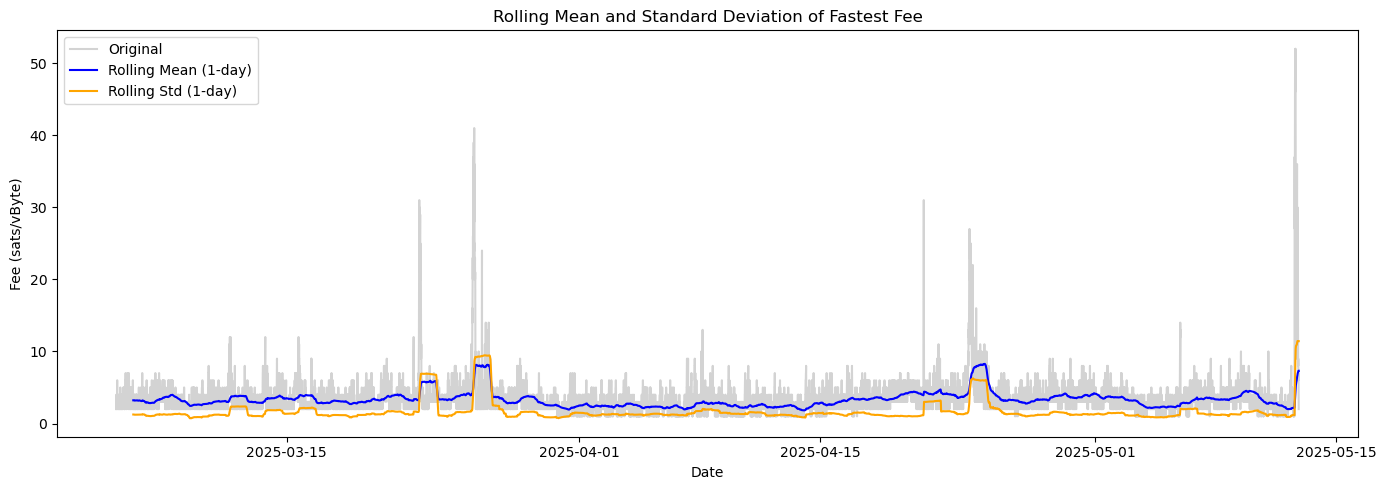

In [28]:
window = 288  # 1-day window for 5-min data

rolling_mean = df["recommended_fee_fastestFee"].rolling(window=window).mean()
rolling_std = df["recommended_fee_fastestFee"].rolling(window=window).std()

plt.figure(figsize=(14, 5))
plt.plot(df["recommended_fee_fastestFee"], color="lightgray", label="Original")
plt.plot(rolling_mean, color="blue", label="Rolling Mean (1-day)")
plt.plot(rolling_std, color="orange", label="Rolling Std (1-day)")
plt.title("Rolling Mean and Standard Deviation of Fastest Fee")
plt.xlabel("Date") 
plt.ylabel("Fee (sats/vByte)")
plt.legend()
plt.tight_layout()
plt.show()

### 6.3 Augmented Dickey-Fuller (ADF) Test

We perform the Augmented Dickey-Fuller (ADF) test to assess the stationarity of the `recommended_fee_fastestFee` series. Understanding whether the series is stationary helps inform the choice of appropriate modeling techniques in subsequent steps.

In [29]:
# Perform ADF test on the target feature
adf_result = adfuller(df["recommended_fee_fastestFee"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -14.958774804844712
p-value: 1.248583891042208e-27
Critical Value (1%): -3.4307
Critical Value (5%): -2.8617
Critical Value (10%): -2.5668


#### Key Insights from ADF Test:

- The ADF test result shows a test statistic of **-14.96**, which is significantly lower than all critical values at the 1%, 5%, and 10% levels.  
- The p-value is effectively zero (**1.25e-27**), providing strong evidence to reject the null hypothesis of non-stationarity.
- This suggests that the `recommended_fee_fastestFee` series is **statistically stationary when assessed over the entire period**.

### 6.4 Week-by-Week Stationarity Analysis

However, as observed in the rolling mean and seasonal decomposition plots, the series exhibits **localized volatility spikes** and **temporary structural shifts**. These fluctuations are not captured by the global ADF test, which motivates further investigation to assess **local or segment-wise stationarity**.

Therefore, we segment the dataset into weekly chunks (2016 rows per week based on 5-minute intervals) and run the Augmented Dickey-Fuller (ADF) test separately on each chunk.  

This allows us to examine **short-term local stationarity**, helping detect temporal shifts, modeling instabilities, or unexpected bursts in fee dynamics. If any week's p-value greater than significance level, it would indicate **non-stationarity**, prompting further segmentation or modeling adjustments.

In [30]:
# Create custom weekly index
start_time = df.index.min()
df['custom_week'] = ((df.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Get max available full weeks
max_week = df['custom_week'].max()

# Run ADF for each week
results = []

for week in range(1, max_week):
    series = df[df['custom_week'] == week]['recommended_fee_fastestFee'].dropna()
    if len(series) >= 50:
        p_val = adfuller(series)[1]
        results.append({'week': week, 'p_value': p_val})
    else:
        results.append({'week': week, 'p_value': None})

weekly_adf_df = pd.DataFrame(results)
weekly_adf_df['p_value'] = weekly_adf_df['p_value'].apply(
    lambda x: f"{x:.4e}" if pd.notnull(x) else "Insufficient Data"
)

display(weekly_adf_df)

,week,p_value
0,1,5.0130e-10
1,2,4.8604e-10
2,3,6.1720e-09
3,4,1.2239e-05
4,5,4.2756e-09
5,6,1.3445e-12
6,7,1.0003e-24
7,8,3.7207e-04
8,9,8.4836e-20


> **Note:** We excluded the final few days of the dataset from the week-by-week ADF test because they do not form a complete 7-day window. Including an incomplete segment could produce unreliable test statistics due to insufficient sample size.

#### Key Insights from Weekly ADF Test:

- Each of the ten 7-day segments shows a **p-value well below** the 1%, 5%, and 10% critical thresholds, confirming that the target series is **locally stationary** throughout.
- Combined with Section 8.2's global ADF result, we conclude that the `recommended_fee_fastestFee` series is **statistically stationary both overall and within short-term windows**.
- This validation supports the use of time sereis models that assume stationarity without needing differencing or structural fixes.

## 7. Target Exploration: Trend and Seaonality

We explore the temporal structure of the target variable `recommended_fee_fastestFee` to identify possible long-term trends and short-term seasonality patterns. We've retained original 5-minute interval data structure with daily periodicity (`period=288`) and applied both additive and multiplicative decomposition methods.

### 7.1 Additive Decomposition 

The additive decomposition of the `recommended_fee_fastestFee` assumes that the time series can be expressed as the sum of its components:
- **Trend**: Long-term movement in the data 
- **Seasonality**: Regular, repeating patterns (e.g., daily cycles)
- **Residual**: Random noise or anomalies not explained by trend or seasonality

This method is suitable when the seasonal fluctuations are roughly constant over time, which is often the case for fee rates that do not exhibit exponential growth or decay. Given the nature of Bitcoin fees where greater fluctuations are expected during periods of high demand, we hypothesis that the additive approach less appropriate than multiplicative decomposition, which assumes that seasonal fluctuations grow or shrink proportionally with the level of the series. But we will apply both methods to compare results.

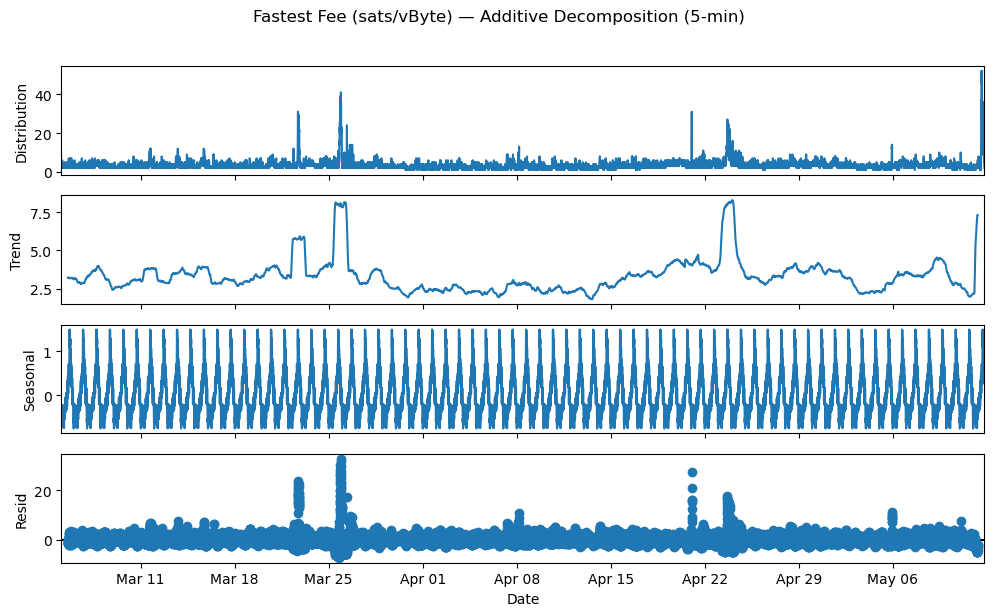

In [31]:
# Use 5-minute resampled data
# period=288 means 288 5-minute intervals = 1 day
plot_decomposition_custom(
    series=df["recommended_fee_fastestFee"],
    model="additive",
    period=288,
    title="Fastest Fee (sats/vByte) — Additive Decomposition (5-min)"
)

### 7.2 Multiplicative Decomposition of Target Feature

We also apply multiplicative decomposition to the `recommended_fee_fastestFee` time series, which also assumes the same components (trend, seasonality, residual) but models them as a product rather than a sum. This method assumes that the seasonal fluctuations are proportional to the level of the series, which is often more appropriate for financial data like transaction fees that can vary widely in magnitude.


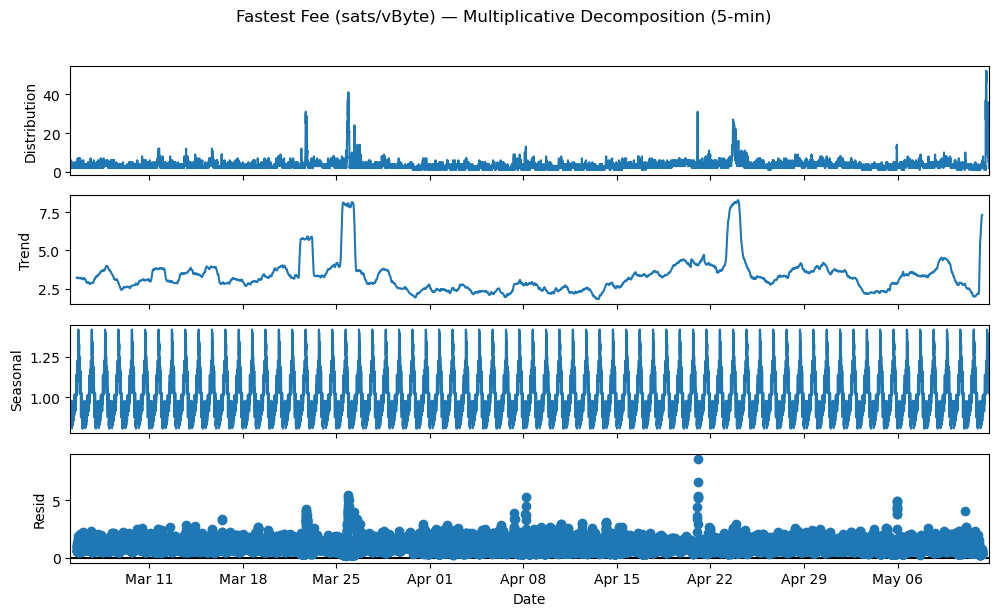

In [32]:
# Multiplicative decomposition using daily periodicity (288 intervals = 24 hours)
plot_decomposition_custom(
    series=df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=288,
    title="Fastest Fee (sats/vByte) — Multiplicative Decomposition (5-min)"
)

### 7.3 Key Takeaways from Decomposition Analysis

Based on the visualizations of both decompositions, we observe that:
- Multiplicative decomposition showes more compact residuals, which indicates that it is better at capturing the underlying structure of the time series.
- The trend component shows a gradual increase and several demand-driven spikes, indicating changing network conditions over time.
- A **daily seasonality pattern** with stable oscillations is observed, confirming 24-hour trading cycles.
- **Significant residual spikes** suggest anomalies or sudden traffic surges that cannot be explained by regular patterns.
- This decomposition validates the presence of both trend and seasonality, supporting their inclusion in forecasting models.

### 7.4 Multiplicative Decomposition Residuals Diagnostics

While we have identified the trend and seasonal components of the `recommended_fee_fastestFee` time series, it is crucial to analyze the residuals to understand the remaining noise and potential autocorrelation structure.

We focus on the multiplicative version because it better captures the proportional seasonal variation in the data. Additive residuals are not analyzed further, as multiplicative decomposition is more appropriate for our scale and volatility.

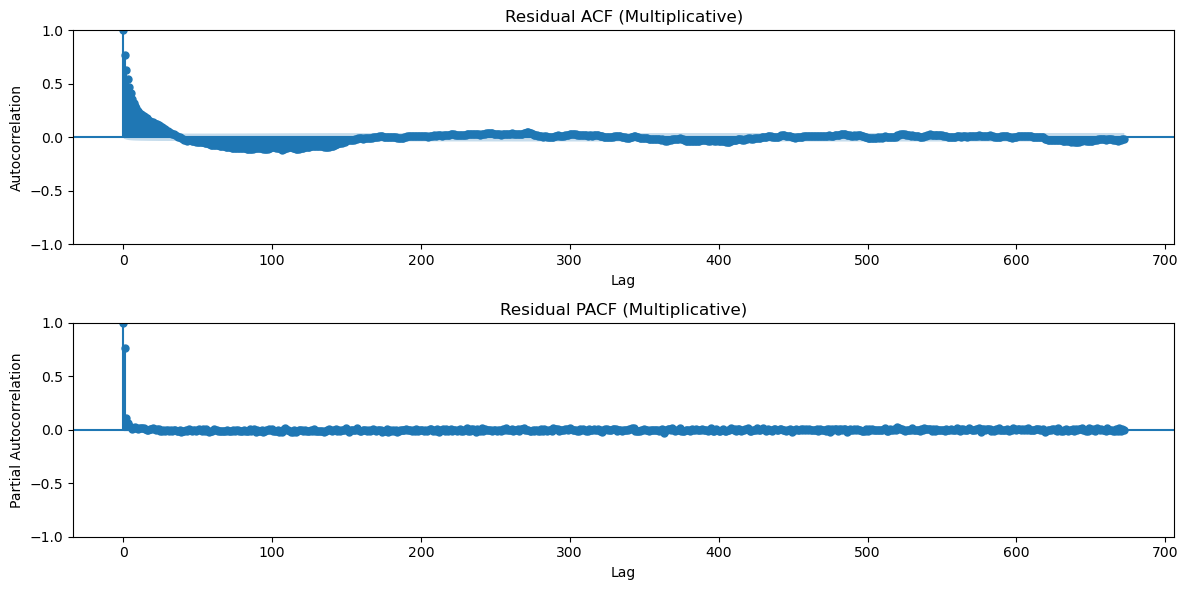

In [33]:
decomp_result_mul = seasonal_decompose(
    df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=288
)

residuals = decomp_result_mul.resid.dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(residuals, ax=ax[0], lags=672, title='Residual ACF (Multiplicative)')
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
plot_pacf(residuals, ax=ax[1], lags=672, title='Residual PACF (Multiplicative)')
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
plt.tight_layout()
plt.show()

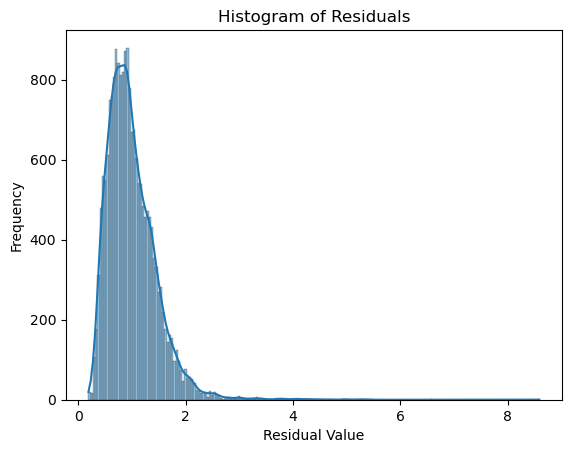

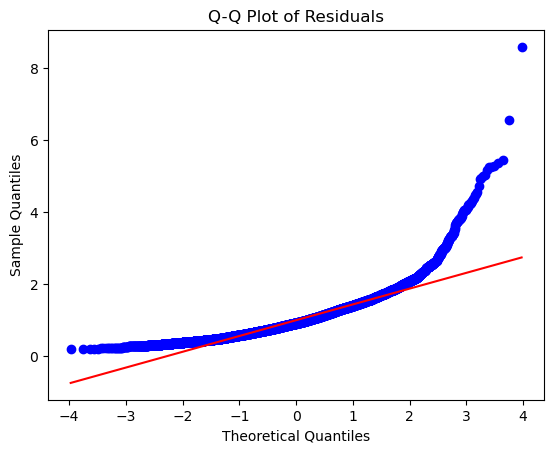

In [34]:
# Histogram
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel("Residual Value") 
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

#### Key Insights from Residual Diagnostics:

- **ACF and PACF plots** show a slow decay rather than an immediate drop, indicating that the residual component still contains short-term autocorrelation.
- **Histogram and Q–Q plot** show that the residuals are right-skewed and deviate from a normal distribution, especially in the tails.

These findings suggest that the residuals are not purely white noise, and may still contain useful signal. Therefore, further investigation—such as segmenting residuals by date or incorporating them into a hybrid modeling approach—may be warranted.

### 7.5 Segmenting Residuals by Week

We segment the residuals from the multiplicative decomposition by week to explore whether volatility or anomalies concentrate in specific time periods. This helps reveal modeling gaps, outlier episodes, or structural shifts.

In [35]:
# Extract residuals from multiplicative decomposition
residuals = decomp_result_mul.resid.dropna().to_frame(name='resid')

# Create custom week index from timestamp
start_time = residuals.index.min()
residuals['week'] = ((residuals.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Calculate summary stats per week
resid_stats = residuals.groupby('week')['resid'].describe()[['mean', 'std', 'min', 'max']]
display(resid_stats)


,mean,std,min,max
week,,,,
1,1.004037,0.390401,0.446874,2.650468
2,0.988728,0.382693,0.429422,3.331061
3,0.985710,0.644294,0.187172,5.443853
4,1.001733,0.438020,0.322735,2.953889
5,0.987427,0.535872,0.274943,5.255535
6,0.998457,0.491819,0.303346,3.095291
7,0.990311,0.453109,0.295460,8.589394
8,1.014180,0.409205,0.357543,2.922734
9,1.005803,0.442656,0.284081,4.953431


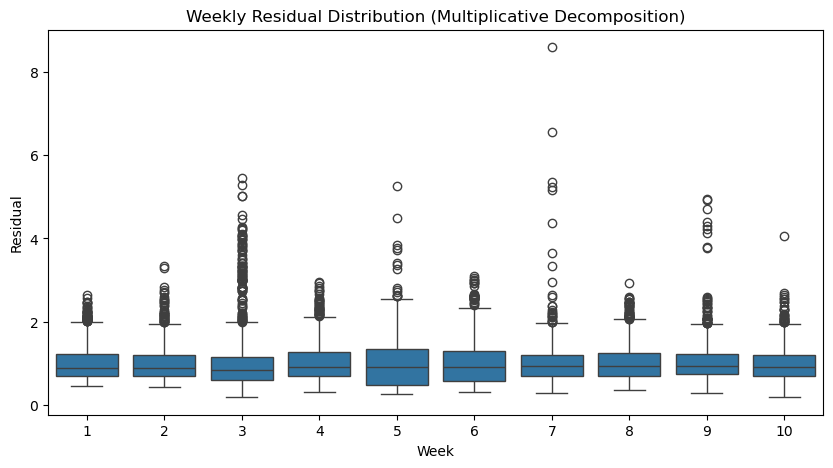

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=residuals, x='week', y='resid')
plt.title('Weekly Residual Distribution (Multiplicative Decomposition)')
plt.ylabel('Residual')
plt.xlabel('Week')
plt.show()

#### Key Insights from Residuals Segementation:

- **Week 3** exhibits the highest residual volatility, with the largest standard deviation (0.64) and a local residual maximum of 5.44. This suggests potential model underfit or unmodeled behavior.
- **Week 5** also shows elevated dispersion and high residual values, supporting the idea of recurring volatility or underperformance.
- **Week 7** contains the most extreme single outlier (residual > 8.5), which may point to an unmodeled event or structural issue.

These results show that residual variance is not uniformly distributed over time, and motivate further refinement of the model to account for time-varying behavior or external shocks.

### 7.6 Multiplicative Decomposition - Weekly Seasonality

While daily seasonality was evident in the multiplicative decomposition, we also explore whether longer-term weekly patterns exist. This is particularly relevant for Bitcoin fees, which may exhibit different congestion dynamics on weekdays versus weekends.

We decomposed the fastest fee series using a 7-day seasonal period (7 * 288 = 2016 intervals based on 5-minute sampling). This allows us to inspect whether weekly patterns—such as weekday vs. weekend congestion—are present in the data.

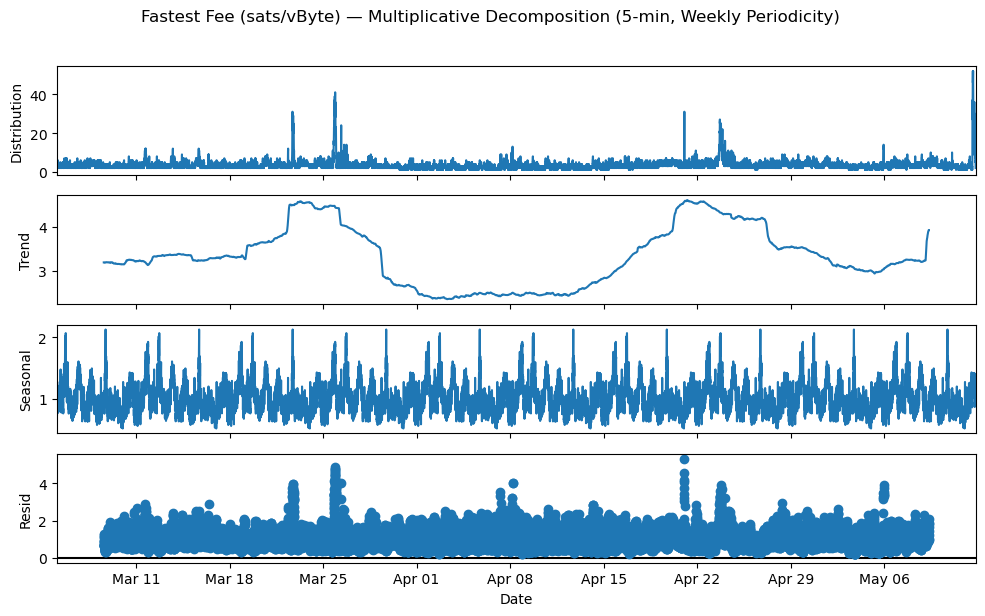

In [37]:
plot_decomposition_custom(
    series=df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=2016,
    title="Fastest Fee (sats/vByte) — Multiplicative Decomposition (5-min, Weekly Periodicity)"
)

#### Key Insights from Weekly Seasonality Decomposition:


- The trend component shows alternating rise and fall segments across the study period, reflecting medium-term shifts in average transaction fee levels.
- The seasonal component exhibits frequent ups and downs that suggest a **dominant daily pattern**. Weekly seasonality appears uneven and overshadowed, with two-day spikes that could stem from sporadic events rather than consistent weekly effects.
- **Residuals remain volatile**, with multiple sharp spikes—especially in the middle weeks—indicating periods of unusual behavior or gaps not captured by the model. *Nonetheless, this decomposition serves as a useful reference when evaluating more advanced models like Prophet, which can explicitly incorporate holiday and irregular event effects.*


## 8. Autocorrelation and Partial Autocorrelation

With stationarity confirmed, we proceed to analyze the autocorrelation and partial autocorrelation structure of the `recommended_fee_fastestFee` series. This step reveals how past values influence future behavior, helping us understand the series' short-term memory and dependency patterns. In addition, the autoregressive (AR) and moving average (MA) components of time series models like ARIMA or SARIMA rely on these insights to determine appropriate lag orders.
- The **Autocorrelation Function (ACF)** helps us assess whether and how current values depend on past values across various lags.
- The **Partial Autocorrelation Function (PACF)** helps us determine the order of autoregressive (AR) components needed in the model.

To capture the full extent of known daily seasonality, we retain the original 5-minute interval structure and set `lags = 288`, corresponding to one full day (24 hours × 12 intervals/hour). This lag horizon is essential for identifying periodic autocorrelation patterns, selecting appropriate model orders (e.g., AR, MA terms), and determining whether daily seasonality should be explicitly modeled in forecasting. It also ensures that the ACF and PACF plots reflect both short-term dynamics and full-cycle dependencies without truncating key seasonal effects.

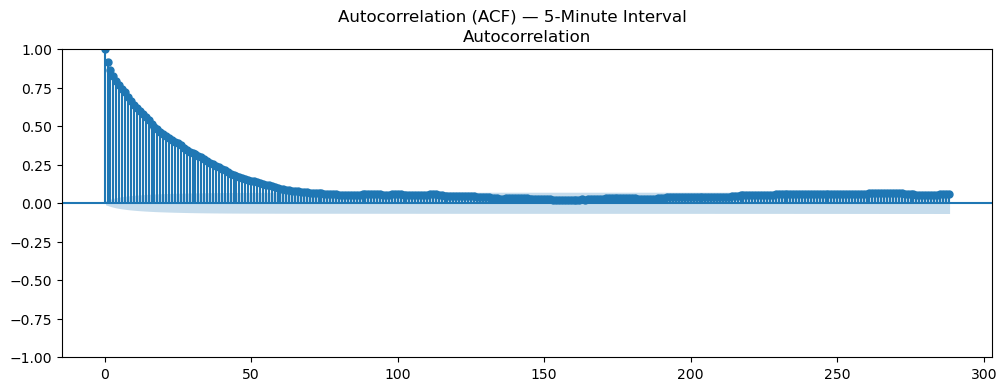

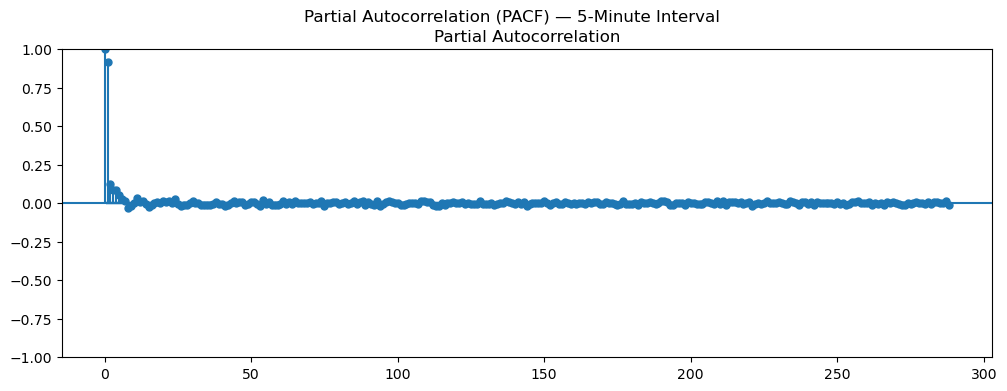

In [38]:
# ACF plot
fig1 = plot_acf(df['recommended_fee_fastestFee'].dropna(), lags=288)
fig1.set_size_inches(12, 4)  # Explicitly set figure size
fig1.suptitle("Autocorrelation (ACF) — 5-Minute Interval")
plt.show()

# PACF plot with Modified Yule-Walker (ywm) for numerical stability at high lags
fig2 = plot_pacf(df['recommended_fee_fastestFee'].dropna(), lags=288, method='ywm')
fig2.set_size_inches(12, 4)  # Explicitly set figure size
fig2.suptitle("Partial Autocorrelation (PACF) — 5-Minute Interval")
plt.show()

#### Key Insights from ACF/PACF Plots:

- The ACF plot shows a slow, gradual decay over time, indicating strong short-term autocorrelation and potential seasonality.
- The PACF plot shows a strong spike at **lag-1** followed by rapid drop-off, suggesting that a **simple AR(1)** structure may be sufficient to capture most of the direct signal.
- These patterns confirm that the `recommended_fee_fastestFee` series exhibits short-term dependencies, which is crucial for selecting an appropriate forecasting model.
- This insight supports the use of AR-based models and motivates further evaluation of sampling intervals in the next section.

## 9. Determine Optimal Sampling Interval for Modeling

Factoring the amount of data we have and the computational cost of modeling (i.e. hyperparameter tuning, training for deep learning models), we now evaluate whether resampling the data to a coarser interval (e.g., 10min, 15min, 30min, etc.) would preserve the short-term signal while reducing noise and computation cost.

### 9.1 Methodology: Decay Ratio Analysis

In the previous section, we confirmed that the `recommended_fee_fastestFee` series exhibits strong short-term autocorrelation — with ACF decaying gradually and PACF showing a sharp spike at lag 1. These patterns suggest that short-term dependencies are present in the original 5-minute data.

To select an interval that balances signal clarity and temporal resolution, we analyzed the **Partial Autocorrelation Function (PACF)** and **decay ratio** at different resampled intervals to evaluate their short-term predictive strength. A good sampling interval should:

- Retain strong short-term signal (PACF at lag-1)
- Minimize oversmoothing or noise (PACF at lag-2)
- Yield a **high decay ratio** (|lag1| / |lag2|), indicating sharp signal decay and better AR model compatibility

Hence we computed:

- **PACF at lag 1**: Indicates short-term dependence.  
- **PACF at lag 2**: Helps assess decay and oversmoothing.  
- **Decay ratio (|lag1| / |lag2|)**: Larger values suggest sharper signal decay and better AR model compatibility.

In [39]:
freqs = ['5min', '10min', '15min', '20min', '30min', '1h']
results = []

for freq in freqs:
    # Resample and drop NA
    resampled = df['recommended_fee_fastestFee'].resample(freq).mean().dropna()

    # Compute PACF up to lag 5
    pacf_vals = pacf(resampled, nlags=5, method='yw')

    # Safety check
    if len(pacf_vals) >= 3:
        lag1 = pacf_vals[1]
        lag2 = pacf_vals[2]
        decay_ratio = abs(lag1) / abs(lag2) if lag2 != 0 else float('inf')

        results.append({
            'frequency': freq,
            'pacf_lag1': round(lag1, 3),
            'pacf_lag2': round(lag2, 3),
            'decay_ratio': round(decay_ratio, 2)
        })

interval_eval_df = pd.DataFrame(results)
display(interval_eval_df.sort_values(by='pacf_lag1', ascending=False))

,frequency,pacf_lag1,pacf_lag2,decay_ratio
0,5min,0.920,0.122,7.54
1,10min,0.905,0.054,16.89
2,15min,0.892,0.010,89.96
3,20min,0.872,-0.016,52.87
4,30min,0.845,-0.127,6.67
5,1h,0.750,-0.162,4.64


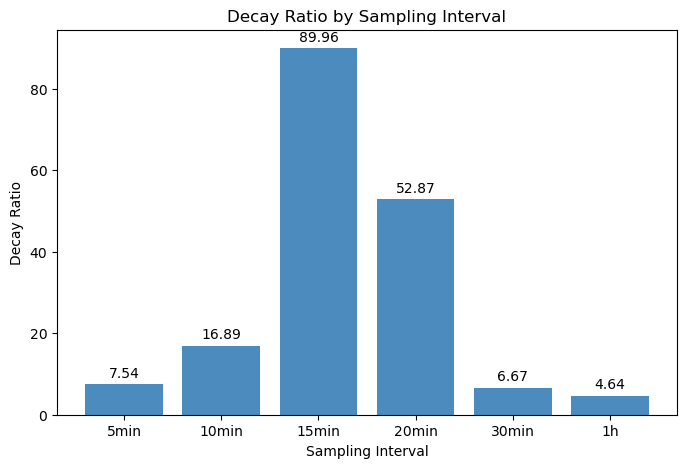

In [40]:
# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.bar(interval_eval_df['frequency'], interval_eval_df['decay_ratio'], color='#4B8BBE')

plt.title('Decay Ratio by Sampling Interval')
plt.ylabel('Decay Ratio')
plt.xlabel('Sampling Interval')

# Annotate bars
for i, val in enumerate(interval_eval_df['decay_ratio']):
    plt.text(i, val + 1, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.show()

#### Key Insights from Decay Ratio Analysis:

- All intervals show strong lag-1 PACF (≥ 0.75), confirming short-term predictability exists across resolutions.  
- The **10-minute interval** shows the strongest lag-1 signal (0.905) and a small lag-2 (0.054), resulting in a high decay ratio (~17).  
- The **15-minute interval** has a slightly weaker lag-1 (0.892) and nearly zero lag-2 (0.010), leading to the **highest decay ratio (~90)**, suggesting excellent signal clarity with minimal noise.  
- Longer intervals like **30min** and **1h** produce negative or unstable lag-2 PACF, indicating possible oversmoothing or structural distortion.  
- The **20-minute interval** also yields a negative decay ratio due to lag-2 ≈ 0, reducing its reliability for modeling.

We therefore recommend using a **15-minute sampling interval** for downstream modeling, as it balances short-term signal clarity and stability without introducing volatility from noise or loss of structure due to oversmoothing.

### 9.2 Target Reassessment at 15-Minute Interval

After selecting the 15-minute interval, we reassess the target variable `recommended_fee_fastestFee` to ensure it retains its key characteristics, including 1) stationarity, 2) trend and seasonality through decomposition, and 3) autocorrelation through ACF/PACF plots. This step is crucial to confirm that the resampled data still captures the essential dynamics of the original series.

After running the decomposition, ADF test, and ACF/PACF analysis on the 15-minute resampled data, we observe that conclusions remain consistent with the original 5-minute series:
- The **ADF test** yields a p-value of 0.0001 both globally and by week, confirming that the resampled series is still stationary.
- The **multiplicative decomposition** shows similar trend and seasonal components, confirming that the 15-minute interval retains the original series' structure.
- The **ACF/PACF plots** show strong lag-1 autocorrelation (0.89) and a rapid drop-off at lag-2 (0.01), indicating that the short-term signal is preserved.

Therefore, we can confidently proceed with modeling using the 15-minute interval data.

In [41]:
# Resample to 15-minute intervals
df_15min = df['recommended_fee_fastestFee'].resample('15min').mean().dropna()

# Perform ADF test on the 15-minute resampled data
adf_result_15min = adfuller(df_15min.dropna())

print("ADF Statistic:", adf_result_15min[0])
print("p-value:", adf_result_15min[1])
for key, value in adf_result_15min[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -15.966378902122312
p-value: 7.084466687137996e-29
Critical Value (1%): -3.4313
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670


In [42]:
# Perform week-by-weekADF test on the 15-minute resampled data
# Make sure the index is datetime
df_15min.index = pd.to_datetime(df_15min.index)

# Create custom week number based on first timestamp
start_time = df_15min.index.min()

# Create custom week index
week_index = ((df_15min.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Assign to DataFrame for grouping
df_temp = pd.DataFrame({'value': df_15min.values, 'custom_week': week_index}, index=df_15min.index)

# Get max full week
max_week = df_temp['custom_week'].max()

# Run ADF for each weekly segment
results = []
for week in range(1, max_week):
    series = df_temp[df_temp['custom_week'] == week]['value'].dropna()
    if len(series) >= 50:
        p_val = adfuller(series)[1]
        results.append({'week': week, 'p_value': p_val})
    else:
        results.append({'week': week, 'p_value': None})

# Format output
weekly_adf_df = pd.DataFrame(results)
weekly_adf_df['p_value'] = weekly_adf_df['p_value'].apply(
    lambda x: f"{x:.4e}" if pd.notnull(x) else "Insufficient Data"
)

display(weekly_adf_df)

,week,p_value
0,1,2.5310e-08
1,2,6.7445e-04
2,3,1.0182e-08
3,4,1.5295e-03
4,5,4.9373e-09
5,6,3.2953e-13
6,7,3.0406e-10
7,8,5.9411e-04
8,9,2.5344e-08


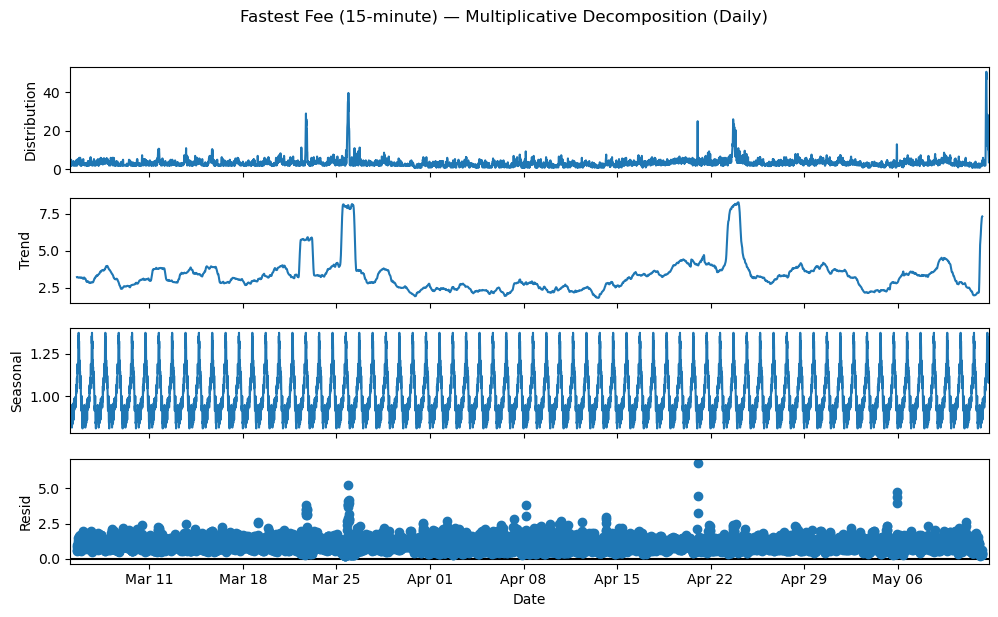

In [43]:
# Perform multiplicative decomposition at 15-minute intervals
# Only the daily seasonlity is considered here based on previous findings
plot_decomposition_custom(
    series=df_15min,
    model="multiplicative",
    period=96,   # Daily seasonality in 15-minute intervals
    title="Fastest Fee (15-minute) — Multiplicative Decomposition (Daily)"
)

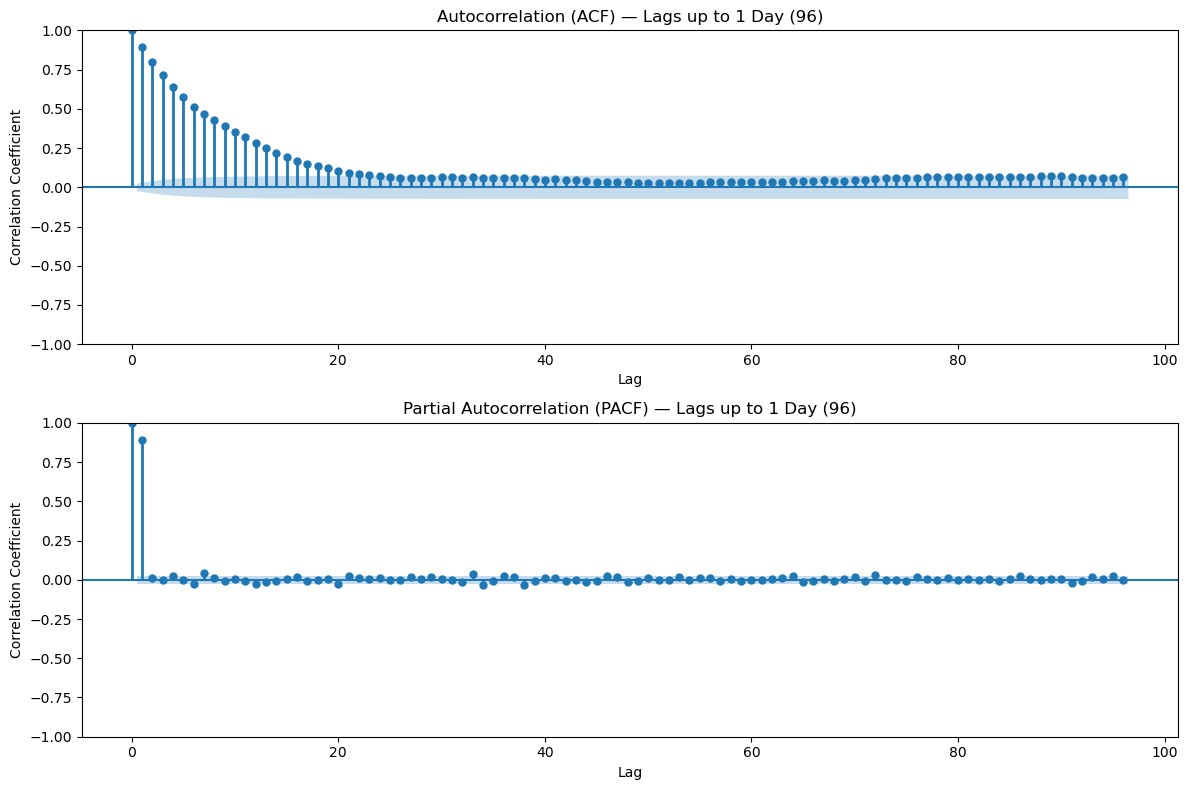

In [44]:
# Plot ACF and PACF for 15-minute data
# Set figure size and layout
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(
    df_15min,  
    lags=96,  # Lags up to 1 day (96 intervals of 15 minutes)
    ax=axes[0],
    vlines_kwargs={'colors': 'C0', 'linestyles': '-', 'linewidth': 2},
    alpha=0.05
)
axes[0].set_ylim(-1, 1)
axes[0].set_title("Autocorrelation (ACF) — Lags up to 1 Day (96)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Correlation Coefficient")

# Plot PACF
plot_pacf(
    df_15min,  
    lags=96,  # Lags up to 1 day (96 intervals of 15 minutes)
    ax=axes[1],
    vlines_kwargs={'colors': 'C0', 'linestyles': '-', 'linewidth': 2},
    alpha=0.05
)
axes[1].set_ylim(-1, 1)
axes[1].set_title("Partial Autocorrelation (PACF) — Lags up to 1 Day (96)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Correlation Coefficient")

plt.tight_layout()
plt.show()

### 9.3 Daily vs Weekly ACF Comparison

To visually contrast daily and weekly autocorrelation patterns, we compare the ACF of the 15-minute resampled series at two lag scales:

- **ACF with lags = 672 (≈ 7 days):** Highlights daily structure, with strong peaks every ~96 lags.
- **ACF with lags = 3360 (≈ 5 weeks):** Used to examine whether weekly structure (lag ≈ 672) is stable and repeated.

We focus on ACF only (not PACF) here because our goal is to inspect repeated cyclical autocorrelation—a hallmark of seasonal structure. PACF is more relevant for identifying short-term lag cutoffs in autoregressive modeling and has already been addressed in earlier sections.

The 5-week window ensures we cover at least 4 complete weekly cycles, offering enough resolution to identify whether autocorrelation peaks recur at multiples of 672 lags (i.e., weekly lags).


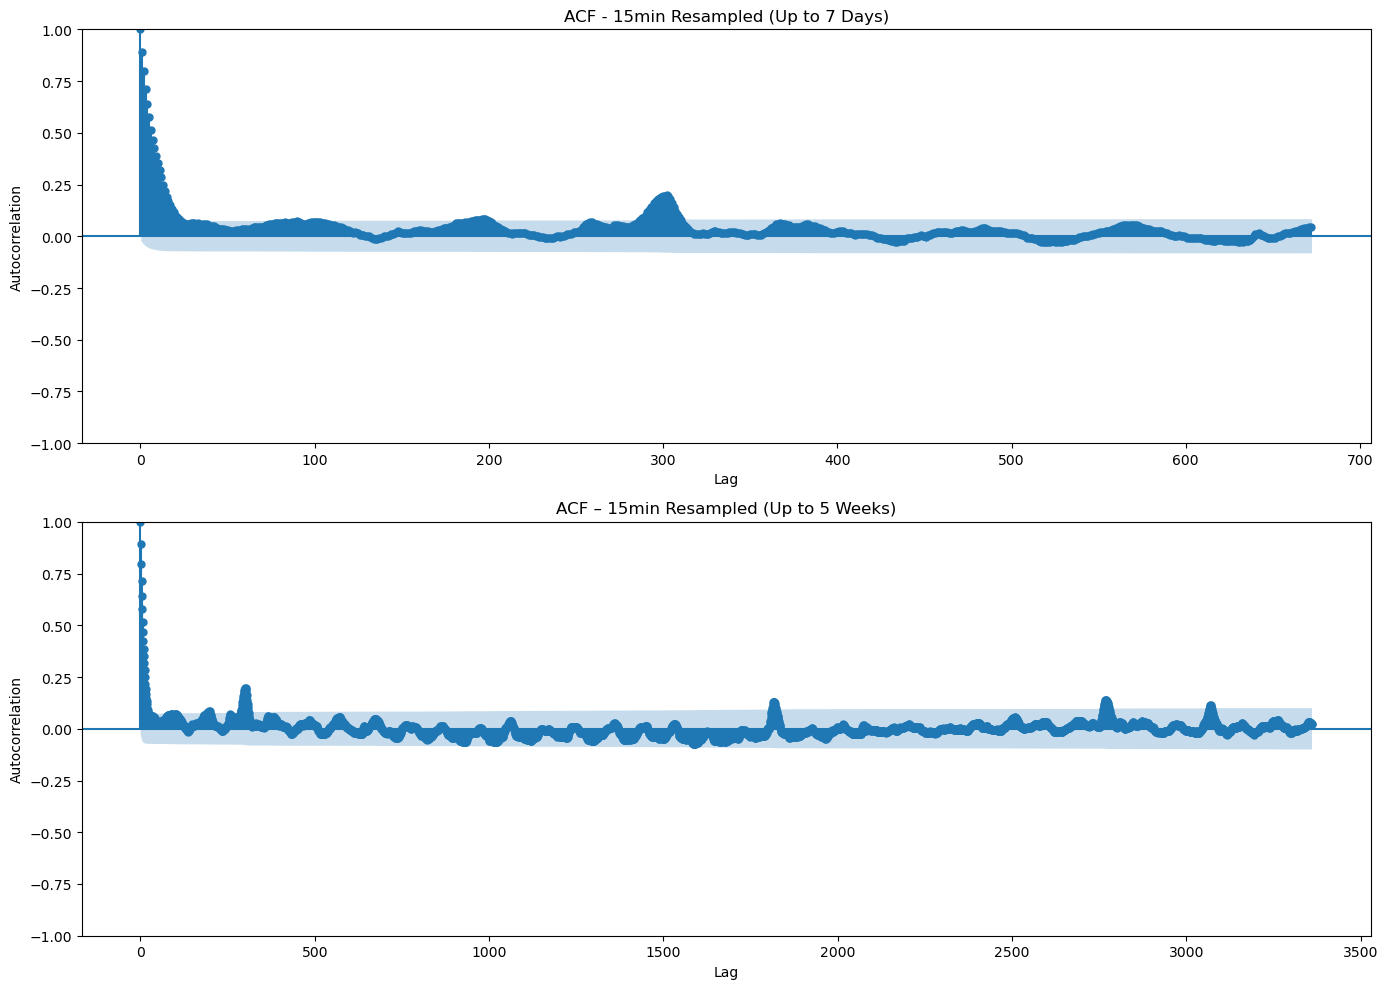

In [45]:
# Set figure size
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Daily scale: 672 lags (~7 days for 15min interval)
plot_acf(df_15min, lags=672, ax=axes[0])
axes[0].set_title("ACF - 15min Resampled (Up to 7 Days)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

# Weekly scale: 3360 lags (~5 weeks for 15min interval)
plot_acf(df_15min, lags=3360, ax=axes[1])
axes[1].set_title("ACF – 15min Resampled (Up to 5 Weeks)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()


#### Key Insights:

- In the **7-day ACF**, a strong autocorrelation peak appears at lag ≈ 96 (i.e., 1 day), confirming clear **daily seasonality**. A smaller bump around lag 288–300 suggests **partial weekend effects**, though not consistently repeated.
- In the **5-week ACF**, no consistent peaks are observed at multiples of 672 (i.e., weekly lags), and the autocorrelation gradually decays beyond ≈ 500 lags. This indicates **no stable or recurring weekly autocorrelation** in the series.
- The absence of consistent long-lag patterns supports the conclusion that the series is **driven by daily cycles**, and **weekly effects are either weak or too irregular to model directly**.
- We will therefore proceed with **daily seasonal modeling** (e.g., `seasonal_period = 96`) in SARIMA or other time series frameworks.


## 10. EDA Summary and Modeling Strategy

After conducting extensive exploratory data analysis (EDA) on the Bitcoin mempool dataset, we have gained valuable insights into the target variable `recommended_fee_fastestFee` and its relationships with other features. This analysis informs our modeling strategy and helps us select appropriate forecasting techniques.

This section distills key insights from the EDA to motivate model choices and guide the forecasting approach.

### 10.1 Key Observations from EDA

- **Sampling Interval:**  
  The 15-minute resampling interval retains short-term signal clarity while reducing noise, making it suitable for modeling.

- **Stationarity:**  
  ADF tests confirm that the target variable `fastestFee` is stationary both globally and by week. Differencing is not needed for ARIMA-family models.

- **Seasonality:**  
  Seasonal decomposition reveals strong and consistent daily cycles. Weekly seasonality was tested but found to be weak and inconsistent.

- **Autocorrelation:**  
  The ACF and PACF plots show strong short-term dependencies, with lag-1 autocorrelation around 0.89 and rapid decay at lag-2. This suggests an AR(1) structure is appropriate.

- **Volatility:**  
  The target exhibits congestion-driven spikes and sharp variability, making it challenging for linear models to fully capture.

- **Multivariate Signals:**  
  The dataset includes a diverse set of features across mempool state, block metrics, difficulty adjustment, and market price—supporting multivariate time series modeling.

- **Correlations:**  
  Features like `mempool_total_fee`, `mempool_blocks_totalFees`, and `mempool_count` are highly correlated with the target, offering strong predictive signals.

### 10.2 Model Strategy

Based on these findings, we adopt a two-stage modeling strategy to balance interpretability, robustness, and forecasting performance.

**Baseline Models**
- **HWES (Holt-Winters Exponential Smoothing):**  
  Captures level and seasonal patterns with minimal tuning; suitable for short-term seasonal forecasting.
- **SARIMA (Seasonal ARIMA):**  
  Leverages autocorrelation and seasonality in a univariate setting (with `seasonal_period = 96`).
- **XGBoost:**  
  A tree-based model capable of handling nonlinearity, lagged inputs, and multivariate dependencies.

**Advanced Models**
- **Prophet:**  
  Decompositional model that handles missing data and strong seasonality well; interpretable and scalable.
- **DeepAR:**  
  Recurrent neural network designed for sequential probabilistic forecasting on time series data.
- **Temporal Fusion Transformer (TFT):**  
  A state-of-the-art attention-based model that captures temporal dependencies and interactions across multiple features with built-in interpretability.

Such modeling strategy allows us to:
- Benchmark traditional univariate time series models (e.g., SARIMA, HWES) against machine learning and deep learning alternatives;
- Assess the added value of incorporating exogenous variables and seasonal terms in multivariate models (e.g., XGBoost, DeepAR, TFT);
- Progressively move toward a performant and interpretable forecasting pipeline.
